Lorenzo Colletta, Giorgio Fantilli, Luca Lucioli

## Parte 1 - Descrizione del problema

Il dataset in esame include dati per la stima dei livelli di obesità negli individui provenienti dai paesi di Messico, Perù e Colombia, in base alle loro abitudini alimentari e alle condizioni fisiche.
Le istanze sono classificate in base al livello di obesità (Peso Insufficiente, Peso Normale, Sovrappeso Livello I, Sovrappeso Livello II, Obesità Tipo I, Obesità Tipo II e Obesità Tipo III). Il 77% dei dati è stato generato artificialmente utilizzando lo strumento Weka e il filtro SMOTE, mentre il 23% dei dati è stato raccolto direttamente dagli utenti attraverso una piattaforma web.

L'obiettivo è predire il livello di obesità dei soggetti utilizzando i loro dati antropometrici, le informazioni sulle loro abitudini alimentari e sull'attività fisica.

Di seguito vengono importate le librerie necessarie per scaricare i file, organizzare le strutture dati e disegnare i grafici.

In [2]:
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dython.nominal import associations, cramers_v
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

### Caricamento dati e preprocessing

In [3]:
file_zip_url = "https://archive.ics.uci.edu/static/public/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition.zip"
file_zip_name = "obesity_data.zip"
file = "./ObesityDataSet_raw_and_data_sinthetic.csv"

if not os.path.exists(file_zip_name):
    from urllib.request import urlretrieve
    urlretrieve(file_zip_url, file_zip_name)
    from zipfile import ZipFile
    with ZipFile(file_zip_name) as f:
        f.extractall()

obesity_raw_data = pd.read_csv(file)
obesity_raw_data = obesity_raw_data.rename(columns={"family_history_with_overweight" : "FHWO", "NObeyesdad" : "ObesityLevel"})

obesity_raw_data.head(10)

,Gender,Age,Height,Weight,FHWO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,ObesityLevel
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II
5,Male,29.0,1.62,53.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight
6,Female,23.0,1.50,55.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,Normal_Weight
7,Male,22.0,1.64,53.0,no,no,2.0,3.0,Sometimes,no,2.0,no,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
8,Male,24.0,1.78,64.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Frequently,Public_Transportation,Normal_Weight
9,Male,22.0,1.72,68.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight


Sopra viene mostrato un piccolo estratto del dataset in esame, dopo aver rinominato alcune feature per migliorarne la leggibilità e l'utilizzo.

Di seguito sono riportate le dimensioni in memoria, il numero di istanze non nulle e il tipo delle feature che compongono i dati raccolti nel dataset.


In [4]:
obesity_raw_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Gender        2111 non-null   object 
 1   Age           2111 non-null   float64
 2   Height        2111 non-null   float64
 3   Weight        2111 non-null   float64
 4   FHWO          2111 non-null   object 
 5   FAVC          2111 non-null   object 
 6   FCVC          2111 non-null   float64
 7   NCP           2111 non-null   float64
 8   CAEC          2111 non-null   object 
 9   SMOKE         2111 non-null   object 
 10  CH2O          2111 non-null   float64
 11  SCC           2111 non-null   object 
 12  FAF           2111 non-null   float64
 13  TUE           2111 non-null   float64
 14  CALC          2111 non-null   object 
 15  MTRANS        2111 non-null   object 
 16  ObesityLevel  2111 non-null   object 
dtypes: float64(8), object(9)
memory usage: 1.1 MB


Osserviamo come molte delle feature sono di tipo `object`. Procediamo di seguito con la trasformazione in variabili categoriche e booleane per limitare la memoria occupata.

In [5]:
categorical = ["Gender", "CAEC", "CALC", "MTRANS", "ObesityLevel"]
boolean = ["FHWO", "FAVC", "SMOKE", "SCC"]

obesity_raw_data[categorical] = obesity_raw_data[categorical].astype("category")

obesity_raw_data[boolean] = obesity_raw_data[boolean].replace({"yes": True, "no": False})

obesity_raw_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Gender        2111 non-null   category
 1   Age           2111 non-null   float64 
 2   Height        2111 non-null   float64 
 3   Weight        2111 non-null   float64 
 4   FHWO          2111 non-null   bool    
 5   FAVC          2111 non-null   bool    
 6   FCVC          2111 non-null   float64 
 7   NCP           2111 non-null   float64 
 8   CAEC          2111 non-null   category
 9   SMOKE         2111 non-null   bool    
 10  CH2O          2111 non-null   float64 
 11  SCC           2111 non-null   bool    
 12  FAF           2111 non-null   float64 
 13  TUE           2111 non-null   float64 
 14  CALC          2111 non-null   category
 15  MTRANS        2111 non-null   category
 16  ObesityLevel  2111 non-null   category
dtypes: bool(4), category(5), float64(8)
memory usage: 15

Osserviamo come tutte le feature sono rileventi per il problema, e soprattutto che nessuna delle stesse presenta valori nulli. Non risulta perciò necessaria nessuna pulizia dei dati.

### Descrizione delle feature
Il dataset contiene le seguenti feature:
*   `Gender`: genere (Male, Female)
*   `Age`: età
*   `Height`: altezza in metri
*   `Weight`: peso in kilogrammi
*   `FHWO`: indica se il soggetto ha familiari che sono o sono stati sovrappeso (yes, no)
*   `FAVC`: indica se il soggetto mangia spesso cibo ad alto contenuto calorico o meno (yes, no)
*   `FCVC`: indica se solitamente il soggetto mangia verdura durante i pasti o meno (Never, Sometimes, Always)
*   `NCP`: indica quanti pasti consuma il soggetto durante la giornata (tra 1 e 2, 3, più di 3)
*   `CAEC`: indica se il soggetto mangia tra i pasti (No, Sometimes, Frequently, Always)
*   `SMOKE`: indica se il soggetto fuma o meno (yes, no)
*   `CH2O`: indica quanta acqua beve il soggetto durante il giorno (meno di 1l, tra 1l e 2l, più di 2l)
*   `SCC`: indica se il soggetto monitora le calorie che assume durante il giorno (yes, no)
*   `FAF`: indica quanto spesso il soggetto svolge attività fisica durante la settimana (mai, 1 o 2 giorni, 2 o 4 giorni, 4 o 5 giorni)
*   `TUE`: indica quanto spesso il soggetto utilizza apparecchi tecnologici durante il giorno come telefono, videogiochi, tv, computer o altri (0-2 ore, 3-5 ore, più di 5 ore)
*   `CALC`: indica quanto spesso il soggetto beve alcool (Never, Sometimes, Frequently, Always)
*   `MTRANS`: indica quale mezzo di trasporto utilizza solitamente il soggetto (Automobile, Motorbike, Bike, Public Transportation, Walking)

La variabile target è `ObesityLevel`, che rappresenta il livello di obesità nelle seguenti classi: Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II, and Obesity Type III.

Le features in esame sono sia categoriche, binarie, che continue:<br>
Tra le categoriche troviamo: `Gender`, `CAEC`, `CALC` e `MTRANS`.<br>
Tra le continue troviamo: `Age`, `Height`, `Weight`, `FCVC`, `NCP`, `CH2O`, `FAF` e `TUE`.<br>
Tra le binarie troviamo: `FHWO`, `FAVC`, `SMOKE` e `SCC`.

Si segnala che `FCVC`, `NCP`, `CH2O`, `FAF` e `TUE` sono feature di natura categorica ma assumono valori continui in quanto una parte dei dati è stata generata artificialmente. Si posticipa la scelta dell'approccio da utilizzare per la gestione di tali variabili.

gender nominale
age continua 
height continua
weight continua
FHWO boolean
FAVC boolean
FCVC ordinale
NCP ordinale
CAEC ordinale
SMOKE boolean
CH2O ordinale
SCC boolean
FAF ordinale
TUE ordinale
CALC ordinale
MTRANS nominale

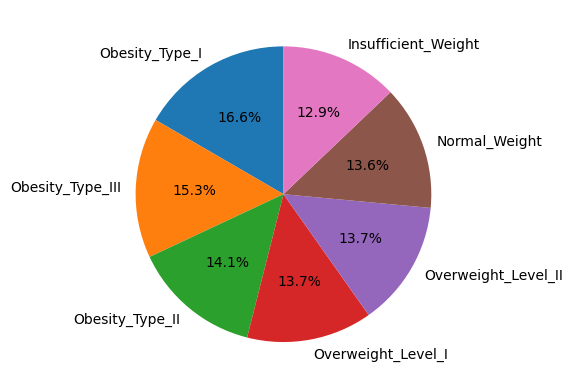

<Figure size 640x480 with 0 Axes>

<Axes: title={'center': 'Distribuzione delle Istanze per Livello di Obesità'}, xlabel='Livello di Obesità', ylabel='Numero di Istanze'>

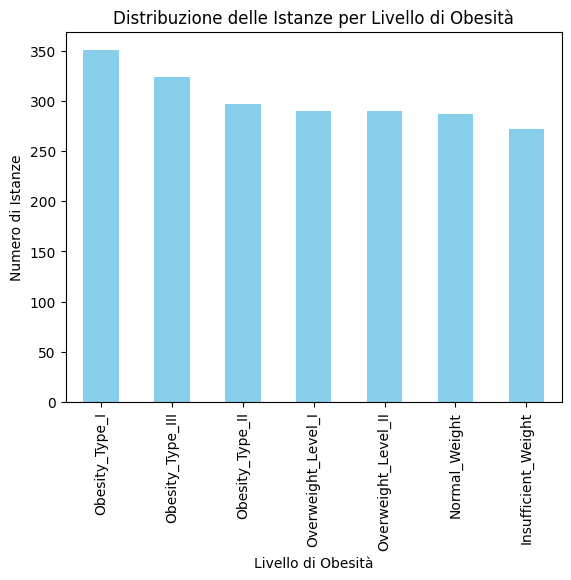

In [6]:
obesity_raw_data["ObesityLevel"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.ylabel(None)
plt.figure().set_facecolor('white')
plt.show()

obesity_raw_data["ObesityLevel"].value_counts().plot.bar(color='skyblue', rot=90, xlabel='Livello di Obesità', ylabel='Numero di Istanze', title='Distribuzione delle Istanze per Livello di Obesità')

Osserviamo dai grafici come la variabile target `ObesityLevel` risulta essere bilanciata, ovvero il numero di istanze per le possibili classi sono pressochè identiche.  Il problema in esame risulta quindi essere bilanciato e non e' necessario utilizzare tecniche di bilanciamento delle classi.

In [7]:
obesity_raw_data.isna().sum()

Gender          0
Age             0
Height          0
Weight          0
FHWO            0
FAVC            0
FCVC            0
NCP             0
CAEC            0
SMOKE           0
CH2O            0
SCC             0
FAF             0
TUE             0
CALC            0
MTRANS          0
ObesityLevel    0
dtype: int64

Si verifica come nessuna delle feature del dataset presenta valori nulli. Osserviamo inoltre che tutte le variabili sono rileventi per la modellazione del problema. Non risulta perciò necessaria nessuna pulizia dei dati.

## Parte 2 - Analisi Esplorativa

### Esplorazione delle feature continue

Di seguito sono riportate le statistiche generali delle feature continue del dataset (media, minimo, massimo, deviazione standard e percentili) e vengono mostrati gli istogrammi relativi alla distribuzione dei loro valori.

In [8]:
obesity_raw_data[['Age', 'Height', 'Weight']].describe()

,Age,Height,Weight
count,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058
std,6.345968,0.093305,26.191172
min,14.000000,1.450000,39.000000
25%,19.947192,1.630000,65.473343
50%,22.777890,1.700499,83.000000
75%,26.000000,1.768464,107.430682
max,61.000000,1.980000,173.000000


Si nota che i soggetti del campione hanno tra i 14 e i 61 anni. Rilevando che il 75% ha meno di 26 anni, la media è di circa 24 anni e la deviazione standard è 6.35, si può ipotizzare che la maggior parte dei soggetti ha tra i 20 e i 30 anni.<br>
Il peso massimo registrato è pari a 173kg ma il 75% dei soggetti pesa meno di 107kg, è perciò probabile la presenza di valori di peso particolari nell'estremo superiore. Nell'estremo inferiore i valori sono invece coerenti con le caratteristiche antropometriche del campione (età e altezza).

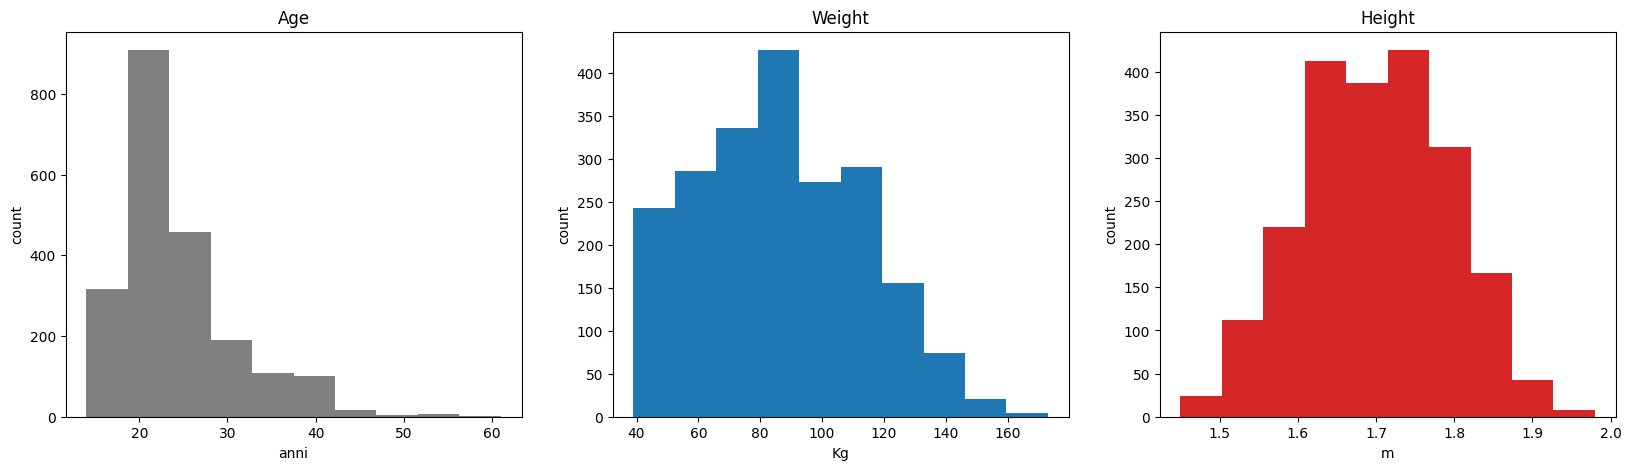

In [9]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.title('Age')
plt.hist(obesity_raw_data['Age'], label="Age", color='gray')
plt.ylabel('count')
plt.xlabel('anni')

plt.subplot(1, 3, 2)
plt.title('Weight')
plt.hist(obesity_raw_data['Weight'], label="weight")
plt.ylabel('count')
plt.xlabel('Kg')

plt.subplot(1, 3, 3)
plt.title('Height')
plt.hist(obesity_raw_data['Height'], label="height", color="tab:red")
plt.ylabel('count')
plt.xlabel('m')
plt.show()

* L'istogramma dell'età conferma l'ipotesi di cui sopra: la maggior parte dei soggetti ha un età compresa tra i 20 e i 30 anni. Si può osservare come il numero delle istanze tenda a diminuire all'avanzare dell'età, diventando trascurabile nella parte finale del grafico.
* Come precedentemente osservato, il grafico del peso rileva una distribuzione delle istanze congrua con il campione, ad eccezione dei valori più alti che risultano poco popolati.
* Il grafico dell'altezza è conforme alla distribuzione attesa per la variabile. 

#### Rimozione degli outliers

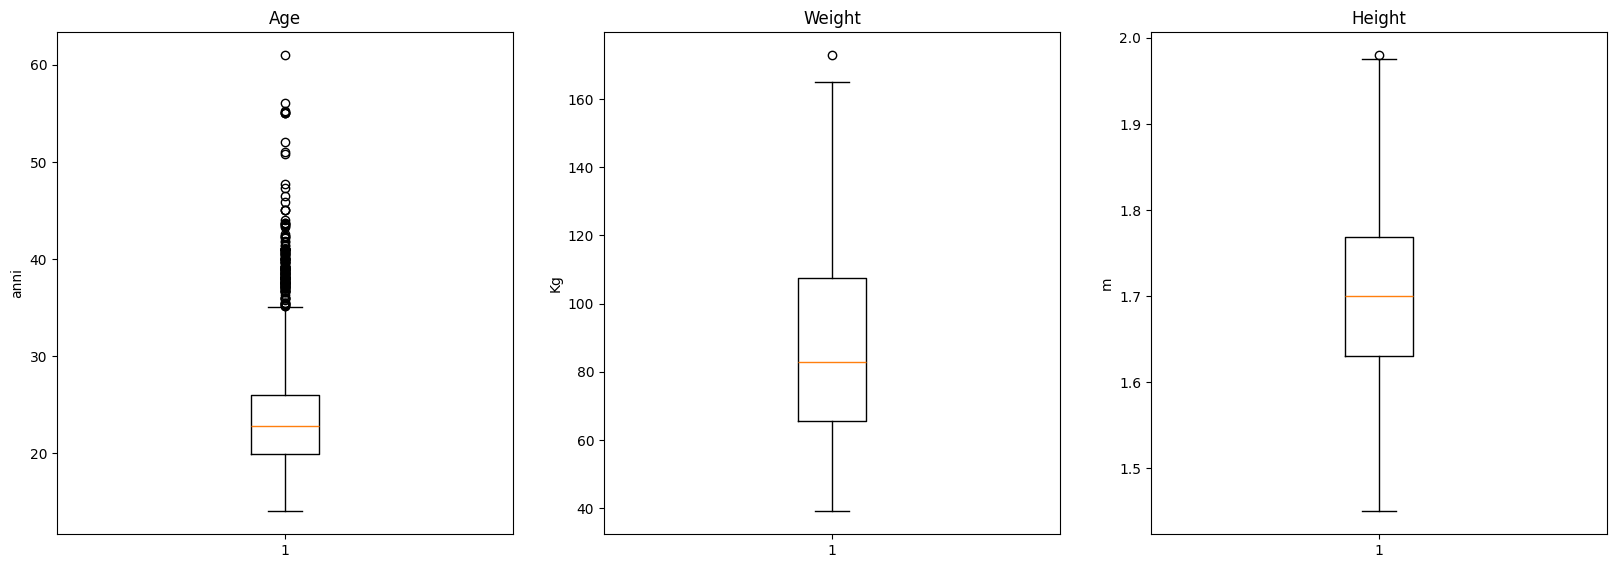

In [10]:
plt.figure(figsize=(20, 30))

plt.subplot(4, 3, 1)
plt.title('Age')
plt.boxplot(obesity_raw_data['Age'])
plt.ylabel('anni')

plt.subplot(4, 3, 2)
plt.title('Weight')
plt.boxplot(obesity_raw_data['Weight'])
plt.ylabel('Kg')

plt.subplot(4, 3, 3)
plt.title('Height')
plt.boxplot(obesity_raw_data['Height'])
plt.ylabel('m')

plt.show()

I grafici sopra permettono di visualizzare meglio la distribuzione dei dati più estremi del campione.<br>
Il primo box plot conferma la tendenza dei record a diminuire con l'aumentare dell'età, in particolare il numero di istanze che assumono un'età superiore a circa 50 anni diventa trascurabile.<br>
Il secondo grafico mostra la presenza di istanze che assumono valori massimi anomali nell'estremità superiore per la variabile del peso, come precedentemente ipotizzato.<br>
La distribuzione delle altezze si conferma corretta, a scanso di isolati valori limite superiori.

Si procede di seguito, in base alle precedenti osservazioni, con la rimozione degli outliers sulla base delle deviazioni standard.

In [11]:
obesity_raw_data.drop(obesity_raw_data.loc[abs(obesity_raw_data['Age'] - obesity_raw_data['Age'].mean()) > 3 * obesity_raw_data['Age'].std()].index, inplace=True)
obesity_raw_data.drop(obesity_raw_data.loc[abs(obesity_raw_data['Weight'] - obesity_raw_data['Weight'].mean()) > 3 * obesity_raw_data['Weight'].std()].index, inplace=True)
obesity_raw_data.drop(obesity_raw_data.loc[abs(obesity_raw_data['Height'] - obesity_raw_data['Height'].mean()) > 3 * obesity_raw_data['Height'].std()].index, inplace=True)

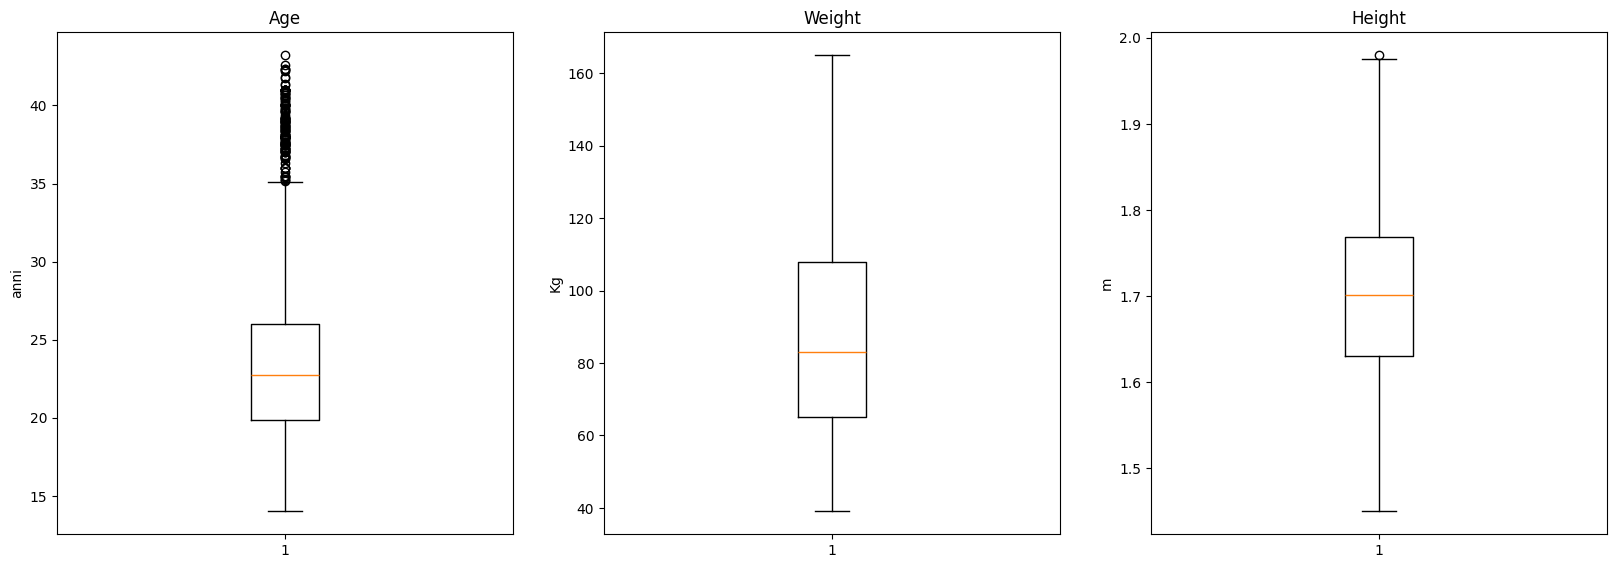

In [12]:
plt.figure(figsize=(20, 30))

plt.subplot(4, 3, 1)
plt.title('Age')
plt.boxplot(obesity_raw_data['Age'])
plt.ylabel('anni')

plt.subplot(4, 3, 2)
plt.title('Weight')
plt.boxplot(obesity_raw_data['Weight'])
plt.ylabel('Kg')

plt.subplot(4, 3, 3)
plt.title('Height')
plt.boxplot(obesity_raw_data['Height'])
plt.ylabel('m')

plt.show()

In [13]:
obesity_raw_data[['Age', 'Height', 'Weight']].describe()

,Age,Height,Weight
count,2086.000000,2086.000000,2086.000000
mean,24.032515,1.702045,86.622985
std,5.776528,0.093419,26.256245
min,14.000000,1.450000,39.000000
25%,19.888210,1.630000,65.130595
50%,22.717596,1.701383,83.000000
75%,26.000000,1.768770,108.009452
max,43.238402,1.980000,165.057269


L'operazione comporta la perdita di sole 25 istanze limite. Dai grafici e dalle statistiche generali delle feature si osserva che sono state rimossi i record con età superiore ai circa 44 anni, con un peso superiore ai circa 165kg; non sono stati cancellati record sulla base dei valori assunti dall'altezza.<br>
Le colonne interessate hanno mantenuto la medesima media, andando invece a migliorare la relativa deviazione standard.

### Esplorazione delle feature continue di natura categorica

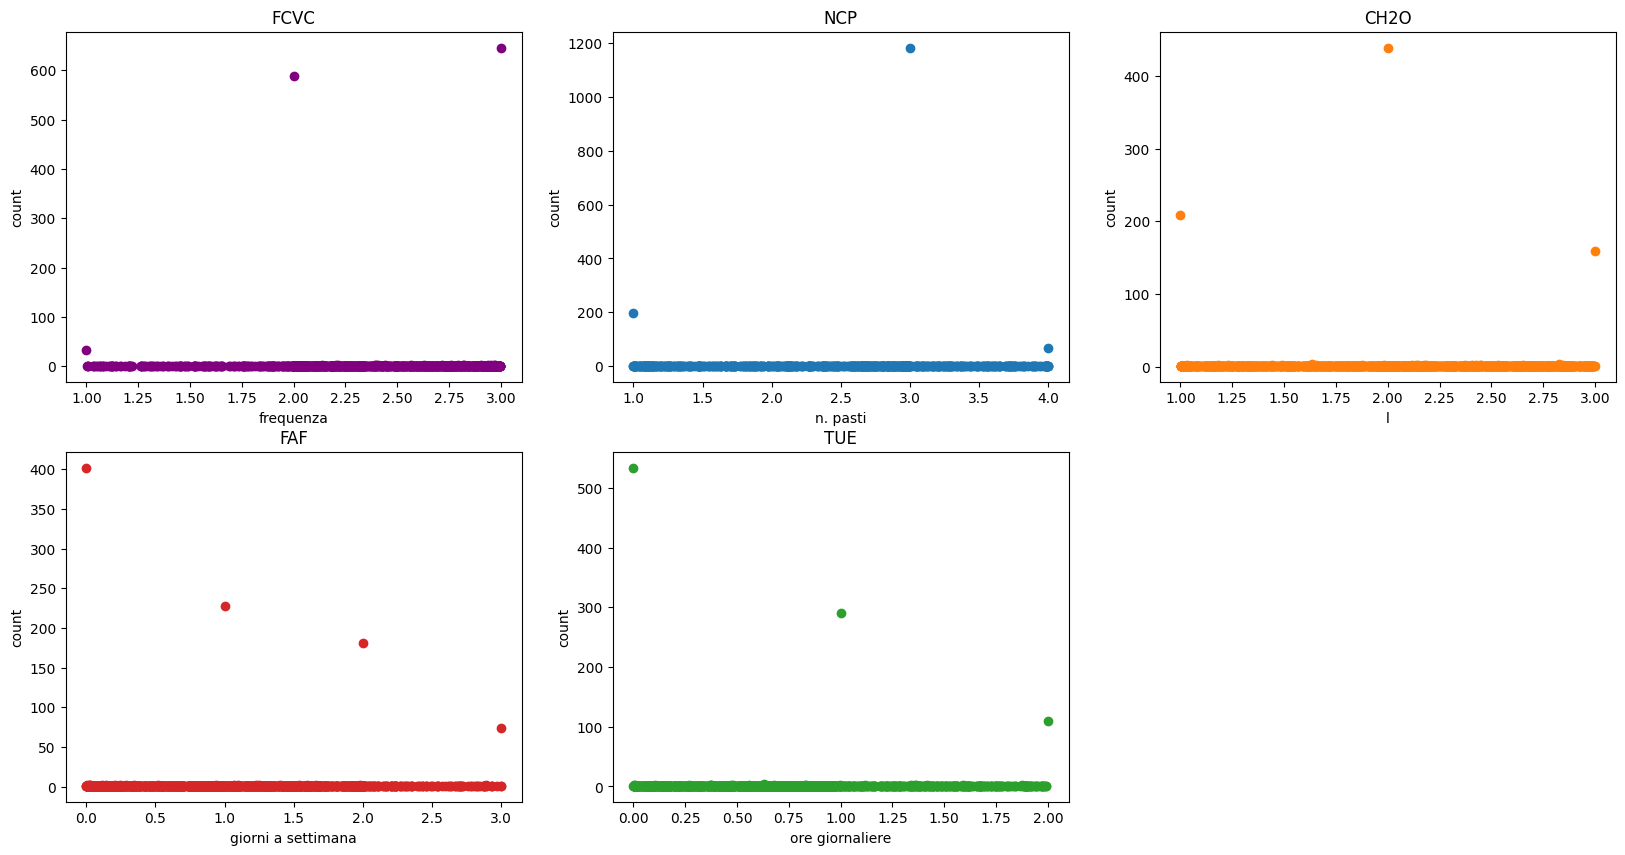

In [14]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.title('FCVC')
fcvc = obesity_raw_data["FCVC"].value_counts()
plt.scatter(fcvc.keys(), fcvc.values, color="purple")
plt.ylabel('count')
plt.xlabel('frequenza')

plt.subplot(2, 3, 2)
plt.title('NCP')
ncp = obesity_raw_data["NCP"].value_counts()
plt.scatter(ncp.keys(), ncp.values)
plt.ylabel('count')
plt.xlabel('n. pasti')


plt.subplot(2, 3, 3)
plt.title('CH2O')
ch2o = obesity_raw_data["CH2O"].value_counts()
plt.scatter(ch2o.keys(), ch2o.values, color="tab:orange")
plt.ylabel('count')
plt.xlabel('l')

plt.subplot(2, 3, 4)
plt.title('FAF')
faf = obesity_raw_data["FAF"].value_counts()
plt.scatter(faf.keys(), faf.values, color="tab:red")
plt.ylabel('count')
plt.xlabel('giorni a settimana')

plt.subplot(2, 3, 5)
plt.title('TUE')
tue = obesity_raw_data["TUE"].value_counts()
plt.scatter(tue.keys(), tue.values, color="tab:green")
plt.ylabel('count')
plt.xlabel('ore giornaliere')

plt.show()

I grafici mostrati sono relativi alle sopracitate variabili di natura categorica ma trattate come continue. Si osserva che la maggior parte delle istanze ricadono precisamente in delle specifiche classi, mentre i restanti valori si distribuiscono in maniera uniforme tra le stesse.
Vista la necessità di ricondursi a valori di tipo categorico si procede con l'arrotondamento al valore intero più vicino.

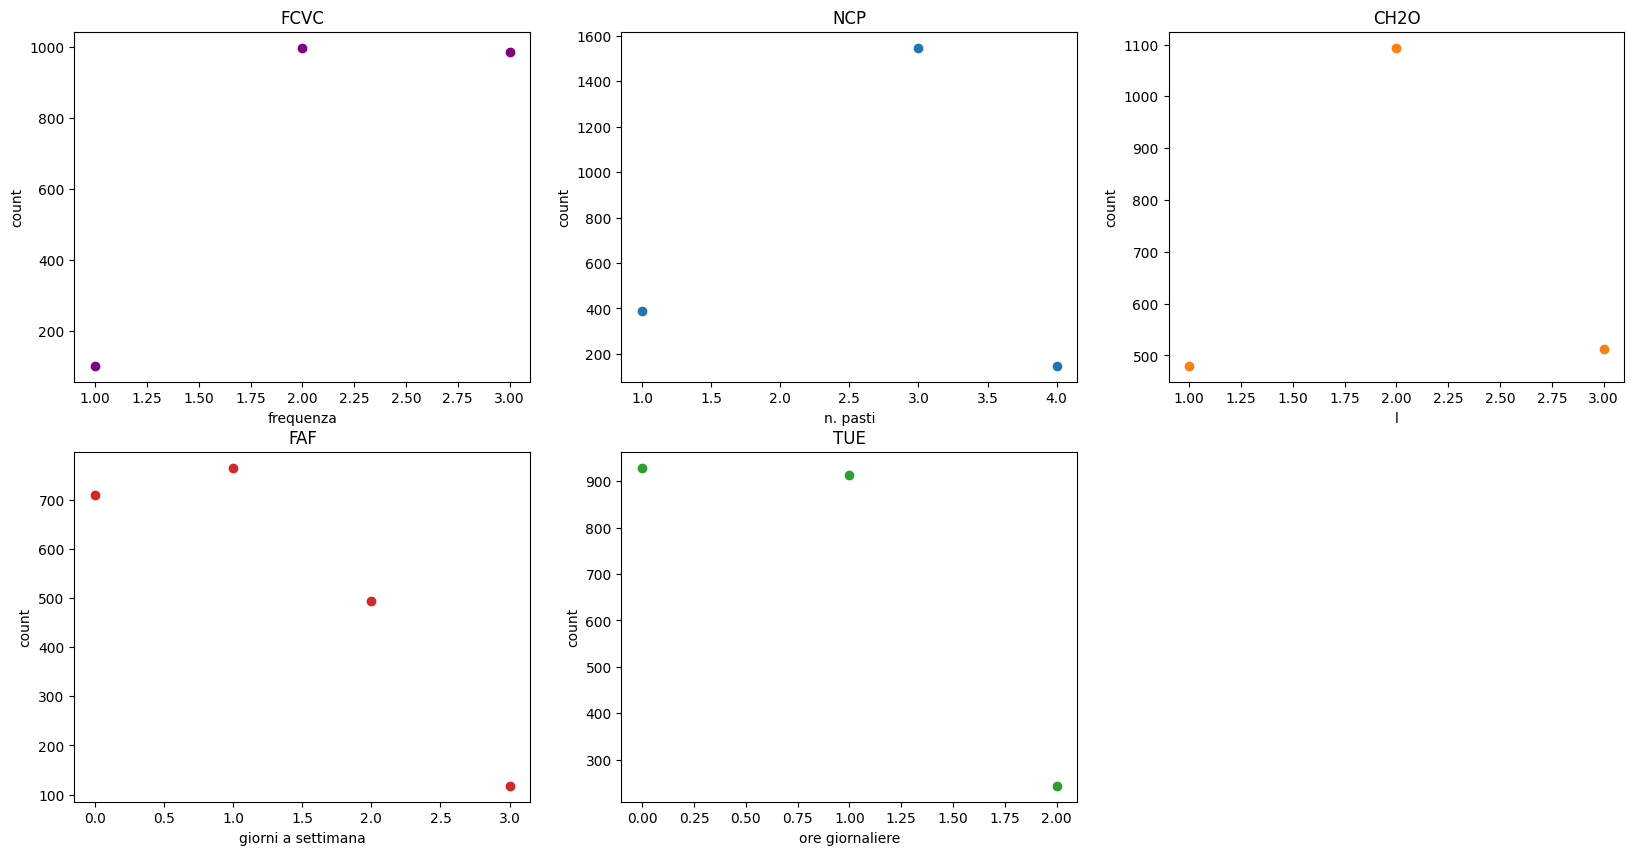

In [15]:
obesity_round_data = obesity_raw_data.copy()
obesity_round_data['NCP'] = obesity_round_data['NCP'].apply(lambda x: 1 if 1 <= x < 2 else (3 if 2 <= x < 3.5 else round(x))).astype(int) 
obesity_round_data['FCVC'] = obesity_round_data['FCVC'].round().astype(int)
obesity_round_data['CH2O'] = obesity_round_data['CH2O'].round().astype(int)
obesity_round_data['FAF'] = obesity_round_data['FAF'].round().astype(int)
obesity_round_data['TUE'] = obesity_round_data['TUE'].round().astype(int)

plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.title('FCVC')
fcvc = obesity_round_data["FCVC"].value_counts()
plt.scatter(fcvc.keys(), fcvc.values, color="purple")
plt.ylabel('count')
plt.xlabel('frequenza')

plt.subplot(2, 3, 2)
plt.title('NCP')
ncp = obesity_round_data["NCP"].value_counts()
plt.scatter(ncp.keys(), ncp.values)
plt.ylabel('count')
plt.xlabel('n. pasti')


plt.subplot(2, 3, 3)
plt.title('CH2O')
ch2o = obesity_round_data["CH2O"].value_counts()
plt.scatter(ch2o.keys(), ch2o.values, color="tab:orange")
plt.ylabel('count')
plt.xlabel('l')

plt.subplot(2, 3, 4)
plt.title('FAF')
faf = obesity_round_data["FAF"].value_counts()
plt.scatter(faf.keys(), faf.values, color="tab:red")
plt.ylabel('count')
plt.xlabel('giorni a settimana')

plt.subplot(2, 3, 5)
plt.title('TUE')
tue = obesity_round_data["TUE"].value_counts()
plt.scatter(tue.keys(), tue.values, color="tab:green")
plt.ylabel('count')
plt.xlabel('ore giornaliere')

plt.show()

Sopra sono riportati i grafici delle feature dopo l'arrotondamento.

Di seguito le statistiche generali delle variabili prima e dopo l'operazione. 

In [16]:
obesity_raw_data[['NCP', 'FCVC', 'CH2O', 'FAF', 'TUE']].describe()

,NCP,FCVC,CH2O,FAF,TUE
count,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000
mean,2.684910,2.419636,2.008721,1.013618,0.664791
std,0.778754,0.534986,0.613157,0.851061,0.608526
min,1.000000,1.000000,1.000000,0.000000,0.000000
25%,2.657909,2.000000,1.582010,0.128702,0.000000
50%,3.000000,2.390173,2.000000,1.000000,0.631320
75%,3.000000,3.000000,2.480485,1.672069,1.000000
max,4.000000,3.000000,3.000000,3.000000,2.000000


In [17]:
obesity_round_data[['NCP', 'FCVC', 'CH2O', 'FAF', 'TUE']].describe()

,NCP,FCVC,CH2O,FAF,TUE
count,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000
mean,2.696069,2.423778,2.015340,1.010067,0.671620
std,0.853630,0.584935,0.689597,0.896245,0.674318
min,1.000000,1.000000,1.000000,0.000000,0.000000
25%,3.000000,2.000000,2.000000,0.000000,0.000000
50%,3.000000,2.000000,2.000000,1.000000,1.000000
75%,3.000000,3.000000,2.000000,2.000000,1.000000
max,4.000000,3.000000,3.000000,3.000000,2.000000


Come si può notare, riportare i valori non interi all'interno delle classi contemplate ha avuto un impatto alquanto limitato sulle statistiche generali delle feature trattate. In particolare media e deviazione standard dimostrano come la distribuzione dei valori sia coerente con la precedene, grazie ad un corretto bilanciamento dei record generati.

### Esplorazione delle feature categoriche

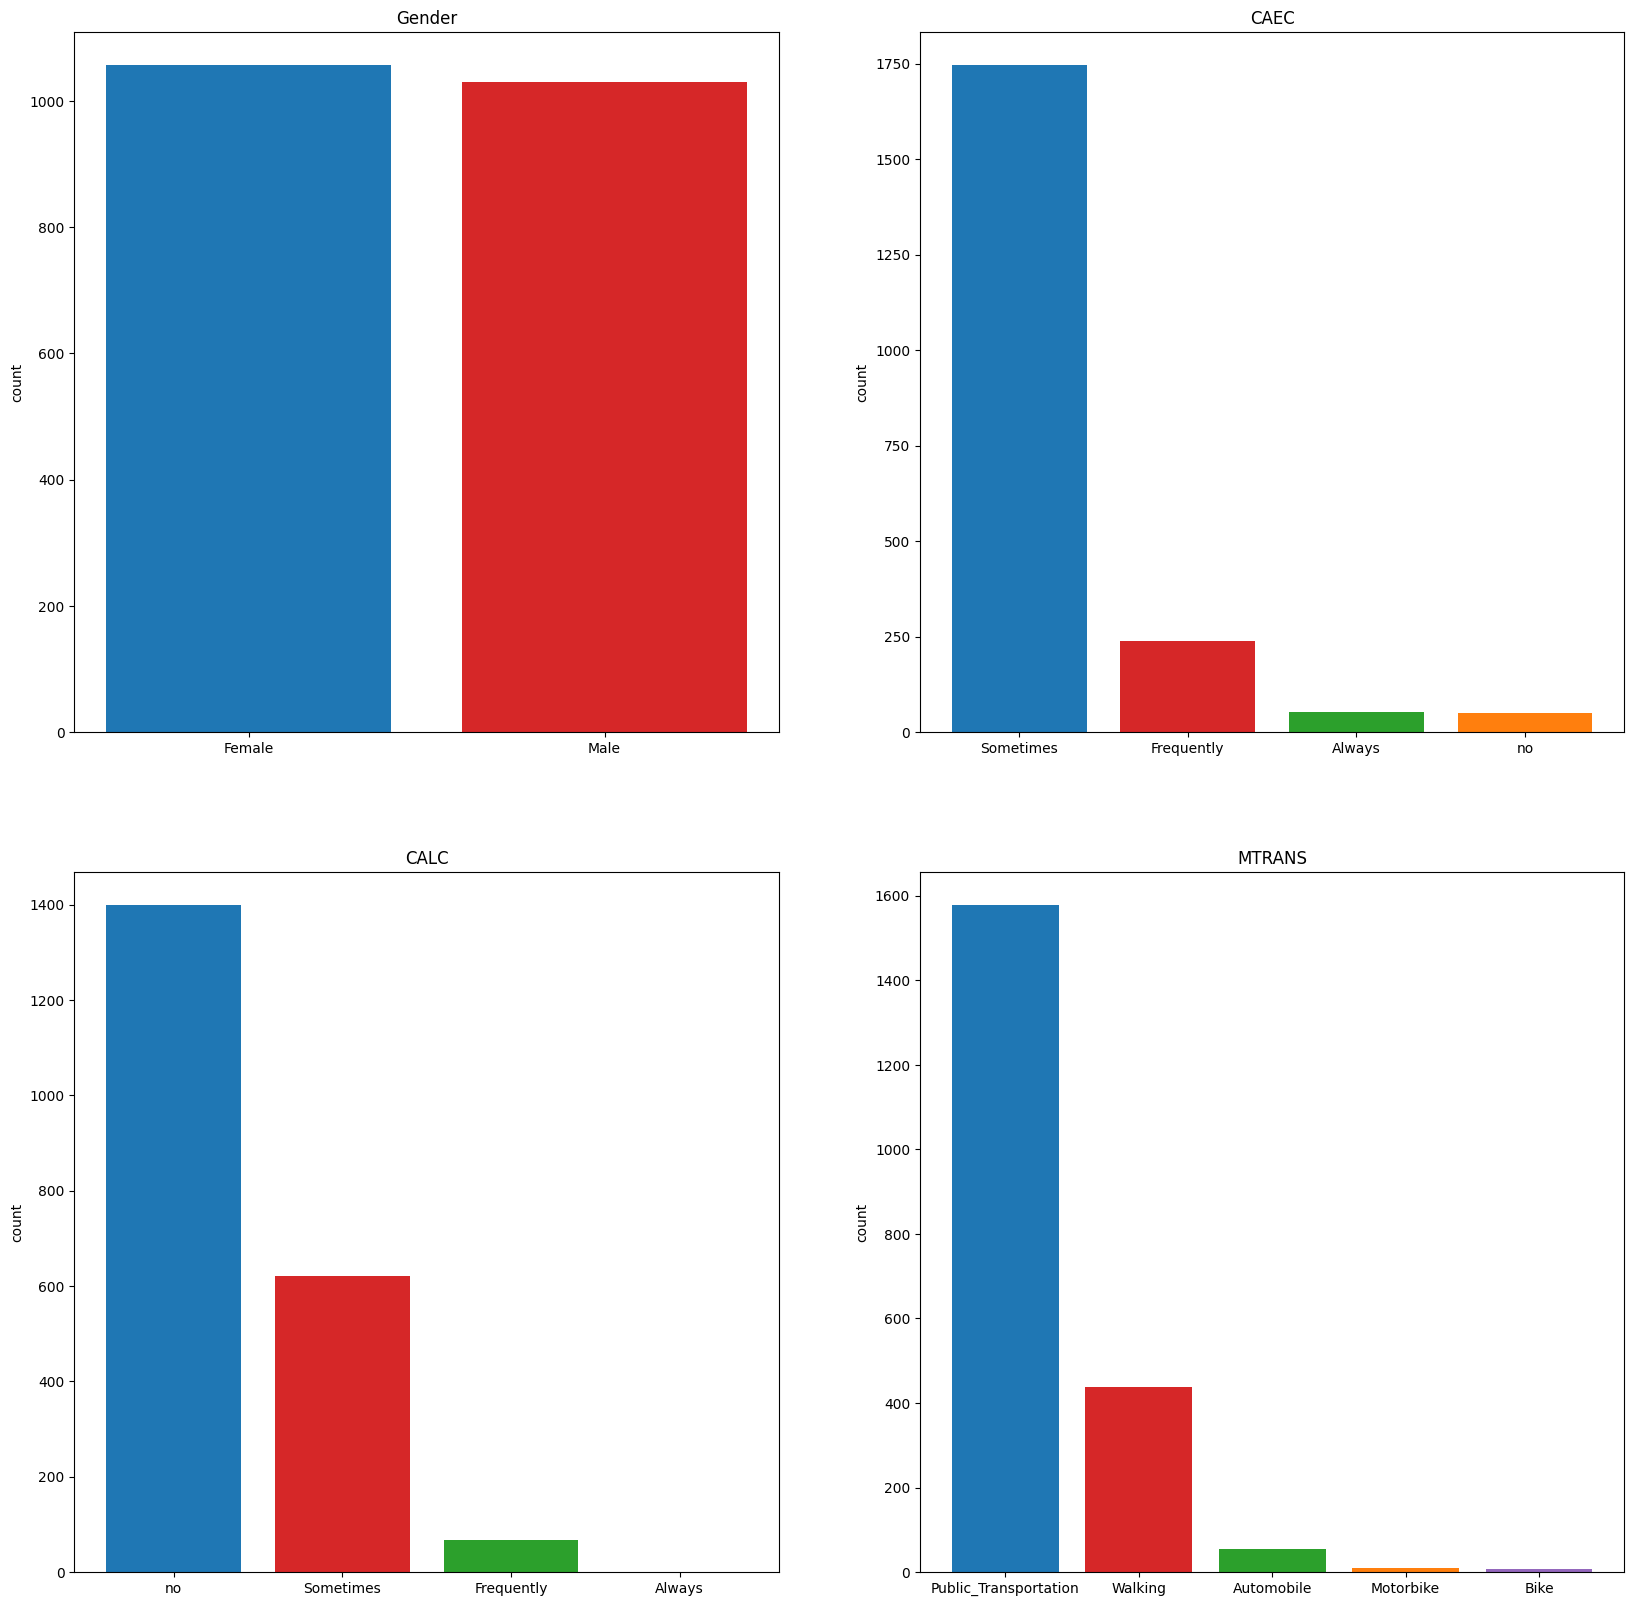

In [18]:
color= ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple']
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.title('Gender')
plt.bar(obesity_raw_data['Gender'].unique(),
        obesity_raw_data['Gender'].value_counts(),
        color=color)
plt.ylabel('count')

plt.subplot(2, 2, 2)
plt.title('CAEC')
plt.bar(obesity_raw_data['CAEC'].unique(),
        obesity_raw_data['CAEC'].value_counts(),
        color=color)
plt.ylabel('count')

plt.subplot(2, 2, 3)
plt.title('CALC')
plt.bar(obesity_raw_data['CALC'].unique(),
        obesity_raw_data['CALC'].value_counts(),
        color=color)
plt.ylabel('count')

plt.subplot(2, 2, 4)
plt.title('MTRANS')
plt.bar(obesity_raw_data['MTRANS'].unique(),
        obesity_raw_data['MTRANS'].value_counts(),
        color=color)
plt.ylabel('count')

plt.show()

Dagli istrogrammi sopra osserviamo che i soggetti sono pressochè equamente distribuiti tra maschi e femmine, mangiano qualche volta tra i pasti, non bevono alcool o molto poco e si muovono principalmente con i trasporti pubblici o a piedi.

### Esplorazione delle feature booleane

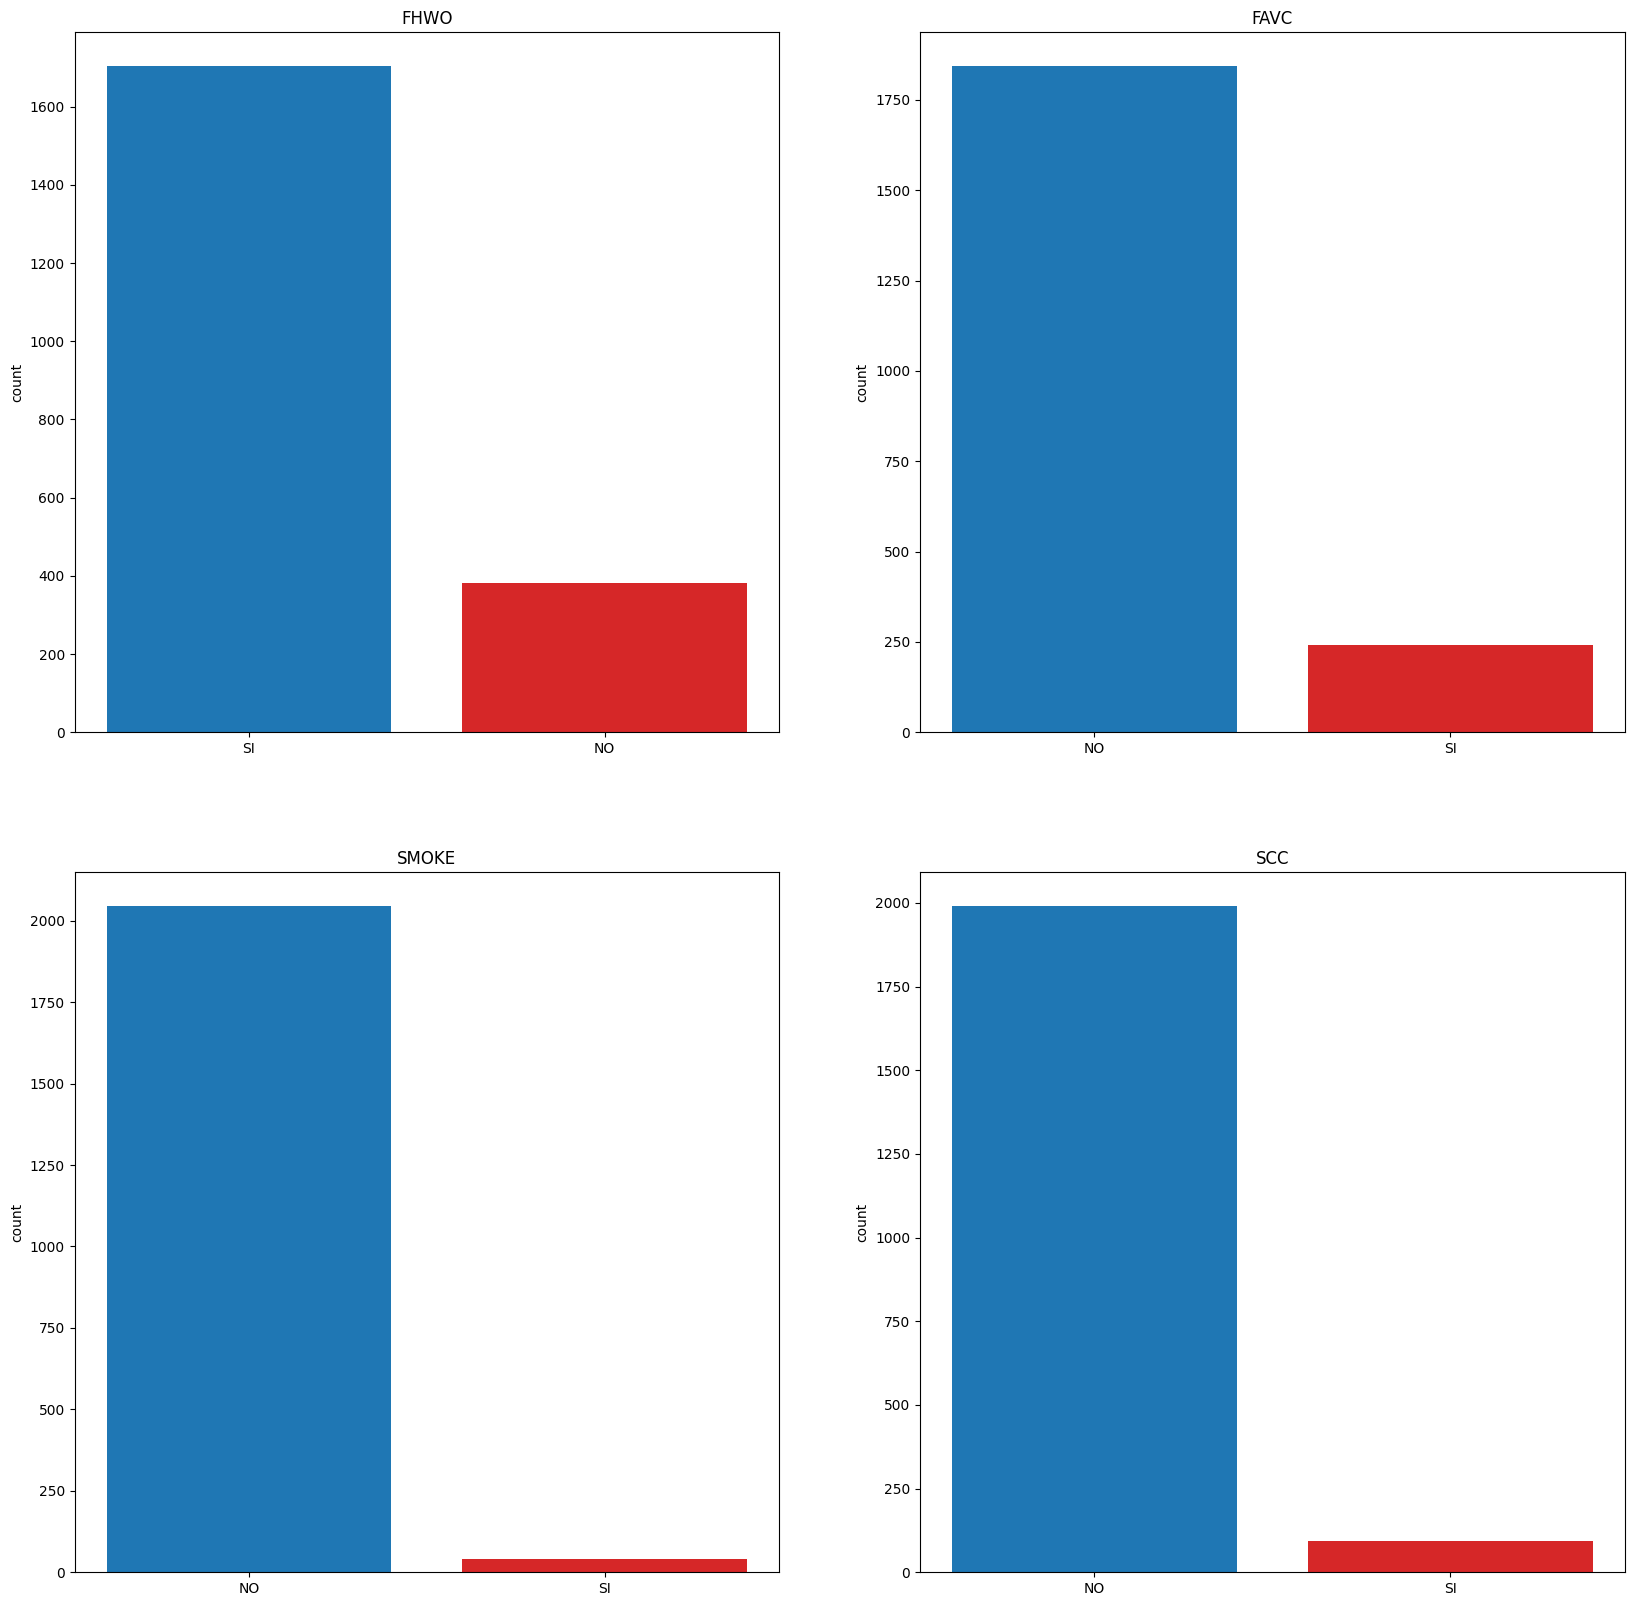

In [19]:
color = ['tab:blue', 'tab:red']
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.title('FHWO')
plt.bar(obesity_raw_data['FHWO'].replace({True: "SI", False: "NO"}).unique(),
        obesity_raw_data['FHWO'].value_counts(),
        color=color)
plt.ylabel('count')

plt.subplot(2, 2, 2)
plt.title('FAVC')
plt.bar(obesity_raw_data['FAVC'].replace({True: "SI", False: "NO"}).unique(),
        obesity_raw_data['FAVC'].value_counts(),
        color=color)
plt.ylabel('count')

plt.subplot(2, 2, 3)
plt.title('SMOKE')
plt.bar(obesity_raw_data['SMOKE'].replace({True: "SI", False: "NO"}).unique(),
        obesity_raw_data['SMOKE'].value_counts(),
        color=color)
plt.ylabel('count')

plt.subplot(2, 2, 4)
plt.title('SCC')
plt.bar(obesity_raw_data['SCC'].replace({True: "SI", False: "NO"}).unique(),
        obesity_raw_data['SCC'].value_counts(),
        color=color)
plt.ylabel('count')

plt.show()

I grafici mostrano un comportamento salubre della maggior parte del campione, essendo composto da pochi fumatori e pochi soggetti che mangiano regolarmente alimenti ad alto contenuto calorico (FAVC). La maggioranza non ha familiari che sono o sono stati sovrappeso e non monitora le calorie che assume.

### Indici di correlazione

In questa sezione si valuteranno le possibili correlazioni tra le varie feature presenti nel dataset.

La funzione sotto permette di rappresentare graficamente le varie matrici di correlazione attraverso una heatmap, permettendo una più facile analisi dei relativi coefficienti.

In [20]:
def plot_correlation(dataset):
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    f, ax = plt.subplots(figsize=(11, 9))

    sns.heatmap(dataset, cmap=cmap, vmax=.5, center=0, annot = True, square=True, linewidths=.5, annot_kws={"size": 12}, fmt=".2f")


Si procede con la codifica delle classi delle variabili categoriche in valori numerici. Si distinguono le feature in continue, categoriche nominali e categoriche ordinali.

In [21]:
dataset = obesity_round_data.copy()

dataset['CAEC'] = dataset['CAEC'].replace({"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3})
dataset['CALC'] = dataset['CALC'].replace({"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3})
dataset['Gender'] = dataset['Gender'].replace({"Female": 0, "Male": 1})
dataset['MTRANS'] = dataset['MTRANS'].replace({"Automobile": 0, "Motorbike": 1, "Bike": 3, "Public_Transportation": 2, "Walking": 4})
dataset['ObesityLevel'] = dataset['ObesityLevel'].replace({'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3, 'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6})

continuous_features = ['Age', 'Height', 'Weight']
nominal_features = ['Gender', 'FHWO', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']
ordinal_features = ['FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE', 'CALC', 'ObesityLevel']

Si calcolano gli indici di correlazione di Pearson tra le feature continue.

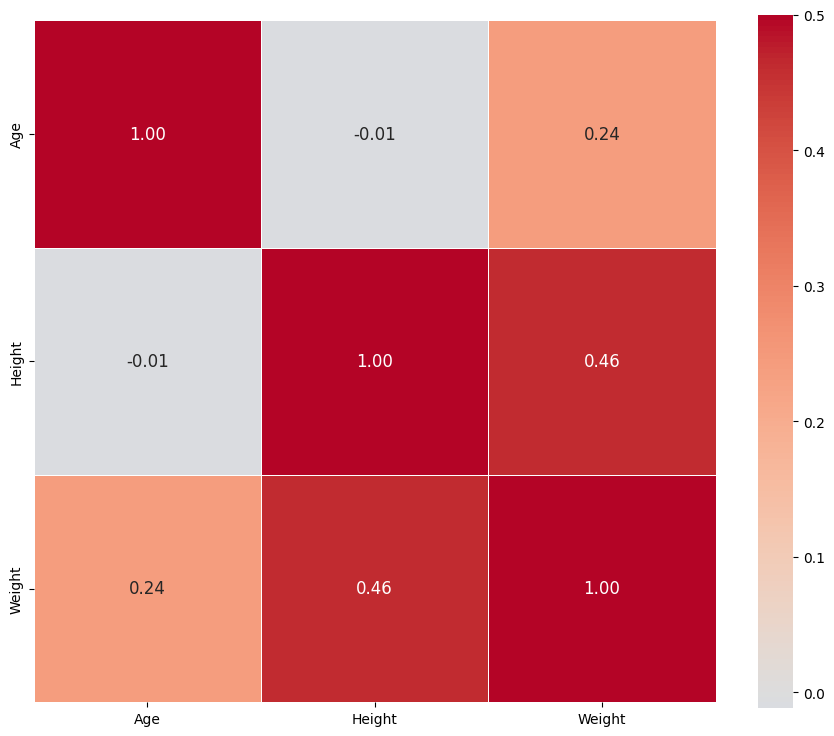

In [22]:
continuos_correlation_matrix = obesity_round_data[continuous_features].corr()
plot_correlation(continuos_correlation_matrix)

Si nota che il peso è debolmente correlato all'età e moderatamente all'altezza.
L'età risulta incorrelata all'altezza.


Si calcolano gli indici di correlazione V di Cramer tra le variabili nominali.

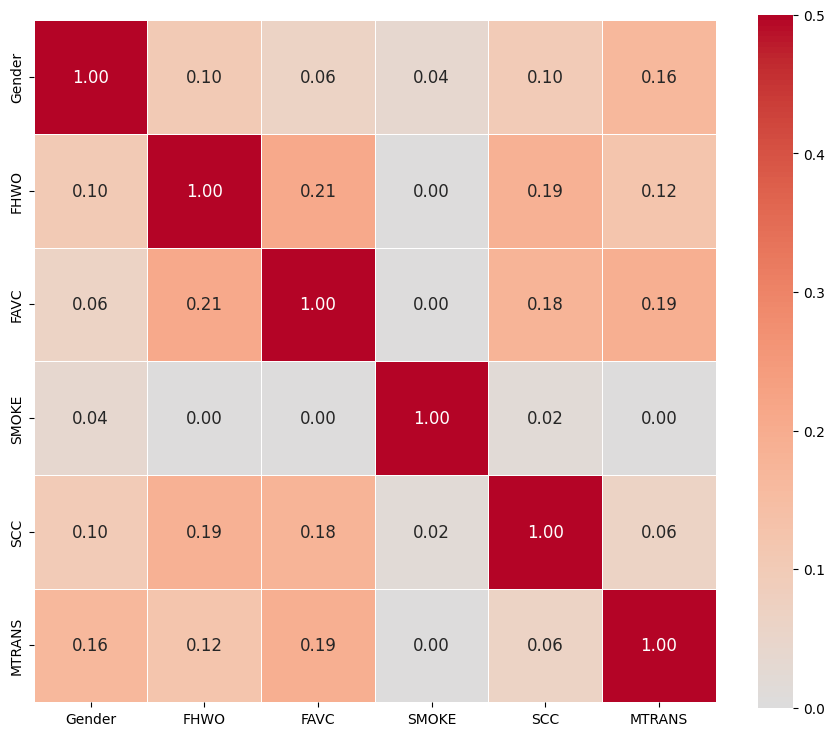

In [23]:
nominal_correlation_matrix = pd.DataFrame(index=nominal_features,
                                     columns=nominal_features, dtype=float)
for col1 in nominal_features:
    for col2 in nominal_features:
        if col1 != col2:
            correlation = cramers_v(obesity_round_data[col1], obesity_round_data[col2])
            nominal_correlation_matrix.loc[col1, col2] = correlation
            nominal_correlation_matrix.loc[col2, col1] = correlation
np.fill_diagonal(nominal_correlation_matrix.values, 1)

plot_correlation(nominal_correlation_matrix)

* il mezzo di trasporto preferito (`MTRANS`) ha una correlazione debole con il genere (`Gender`) e con il consumo di cibi ad alto contenuto calorico (`FAVC`).
* il monitoraggio delle calorie assunte (`SCC`) ha una correlazione debole con il consumo di cibi ad alto contenuto calorico (`FAVC`) e con la presenza di familiari che sono o sono stati in sovrappeso (`FHWO`).
* il consumo di cibi ad alto contenuto calorico (`FAVC`) ha una correlazione moderata con la presenza di familiari che sono o sono stati in sovrappeso (`FHWO`).


Si calcolano gli indici di correlazione di Kendall tra le feature categoriche ordinali.

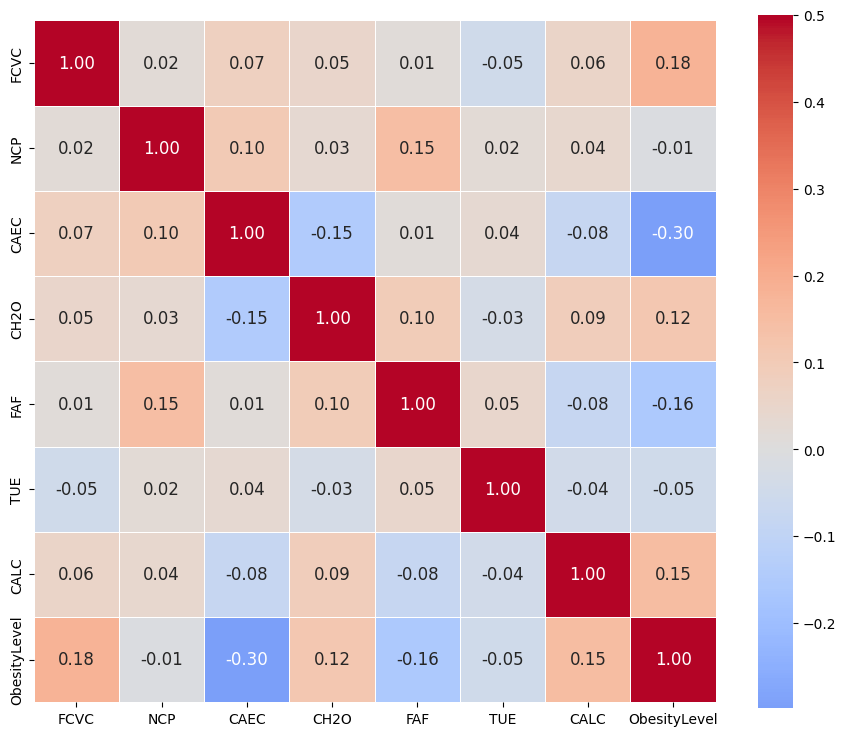

In [24]:
ordinal_correlation_matrix = dataset[ordinal_features].corr(method='kendall')
plot_correlation(ordinal_correlation_matrix)

Si rileva che non ci sono particolari concordanze tra le variabili, ad eccezione di:
* il numero di pasti consumati in una giornata (`NCP`) ha una concordanza molto debole con la frequenza di svolgimento di attività fisica (`FAF`).
* il consumo di cibo tra i pasti (`CAEC`) ha una concordanza negativa molto debole con i litri d'acqua assunti (`CH20`).
* il livello di obesità (`ObesityLevel`) ha una concordanza negativa molto debole con la frequenza di svolgimento di attività fisica (`FAF`), una concordanza negativa debole con il consumo di cibo tra i pasti (`CAEC`) e una concordanza molto debole con la frequenza di assunzione di alcool (`CALC`) e una concordanza molto debole con il consumo di verdure durante i pasti (`FCVC`) e con i litri di acqua assunti (`CH2O`).

La variabile categorica nominale `MTRANS` è multiclasse. Per questo è necessaria l'applicazione del one-hot encoding al fine produrre variabili binarie confrontabili con le altre feature.

In [25]:
dataset = pd.get_dummies(dataset, columns=["MTRANS"])
nominal_features = ['Gender', 'FHWO', 'FAVC', 'SMOKE', 'SCC', 'MTRANS_0', 'MTRANS_1', 'MTRANS_2', 'MTRANS_3', 'MTRANS_4']

Si calcolano gli indici di correlazione point-biserial tra le variabili categoriche nominali e le variabili continue.

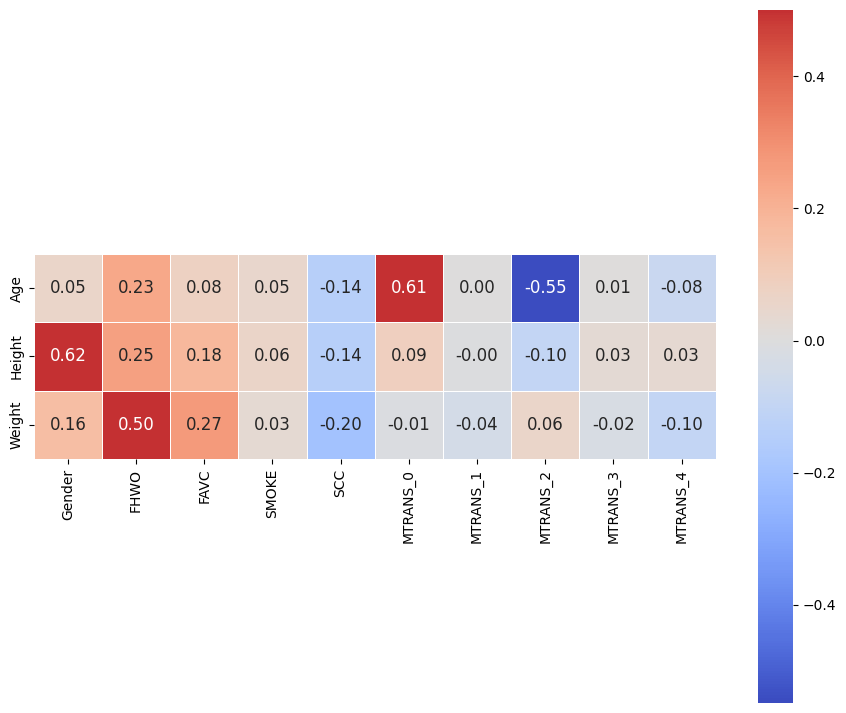

In [26]:
from scipy.stats import pointbiserialr

continuos_nominal_correlation_matrix = pd.DataFrame(index=continuous_features, columns=nominal_features, dtype=float)

for col_cont in continuous_features:
    for col_nom in nominal_features:
        r, p_value = pointbiserialr(dataset[col_nom], dataset[col_cont])
        continuos_nominal_correlation_matrix.loc[col_cont, col_nom] = r

plot_correlation(continuos_nominal_correlation_matrix)


* il peso (`Weight`) ha una correlazione debole con il consumo di cibo ad alto contenuto calorico (`FAVC`), una correlazione moderrata con la presenza di familiari che sono o sono stati in sovrappeso (`FHWO`) e una correlazione negativa debole con il monitoraggio delle calorie assunte(`SCC`).
* l'altezza (`Height`) ha una correlazione debole con la presenza di familiari che sono o sono stati in sovrappeso (`FHWO`) e una correlazione moderata con il genere (`Gender`).
* l'età (`Age`) ha una correlazione debole con la presenza di familiari che sono o sono stati in sovrappeso (`FHWO`), una correlazione moderata con l'utilizzo dell'auto come mezzo di trasporto (`MTRANS_0`) e una correlazione negativa moderata con l'utilizzo della bicicletta come mezzo di trasporto (`MTRANS_2`).

Si calcolano gli indici di correlazione di Spearman tra le variabili categoriche ordinali e quelle continue.

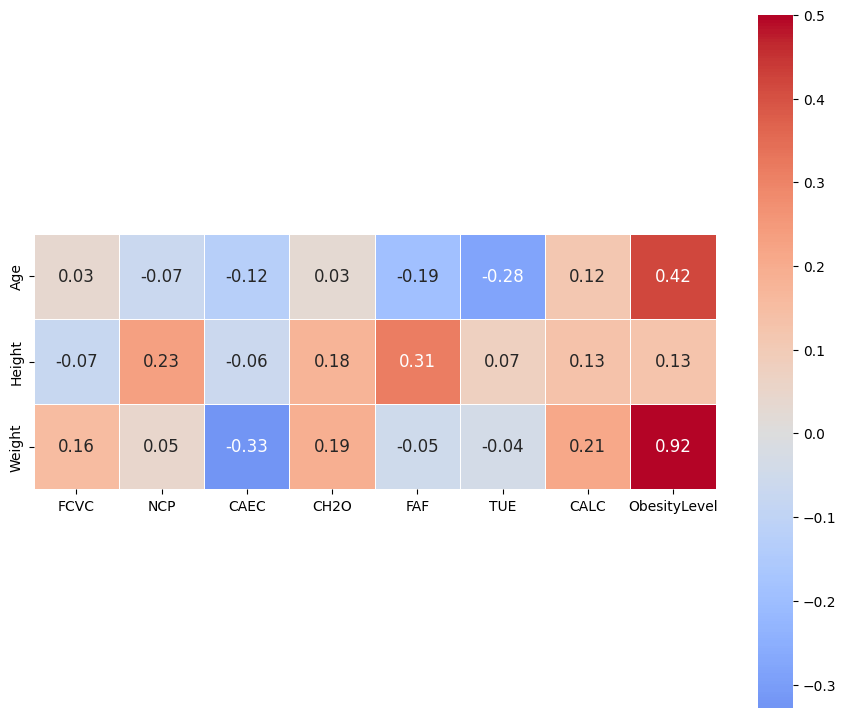

In [27]:
ordinal_continuous_correlation_matrix = dataset[ordinal_features + continuous_features].corr(method='spearman')
plot_correlation(ordinal_continuous_correlation_matrix.iloc[-3:, :-3])

* l'età (`Age`) ha una correlazione negativa molto debole con la frequenza di svolgimento di attività fisica (`FAF`), una correlazione negativa debole con la frequenza di utilizzo di apparecchi tecnologici (`TUE`) e una correlazione moderata con il livello di obesità (`ObesityLevel`).
* l'altezza (`Height`) ha una correlazione molto debole con i litri d'acqua assunti (`CH2O`), una correlazione debole con il numero di pasti consumati in una giornata (`NCP`) e con la frequenza di svolgimento di attività fisica (`FAF`).
* il peso ha una correlazione negativa debole con il consumo di cibo tra i pasti (`CAEC`), una correlazione molto debole con i litri d'acqua assunti (`CH2O`) e con la frequenza di assunzione di alcool (`CALC`) e una correlazione molto forte con il livello di obesità (`ObesityLevel`).

Si calcolano gli indici di correlazione point-biserial tra le variabili categoriche nominali e quelle ordinali.

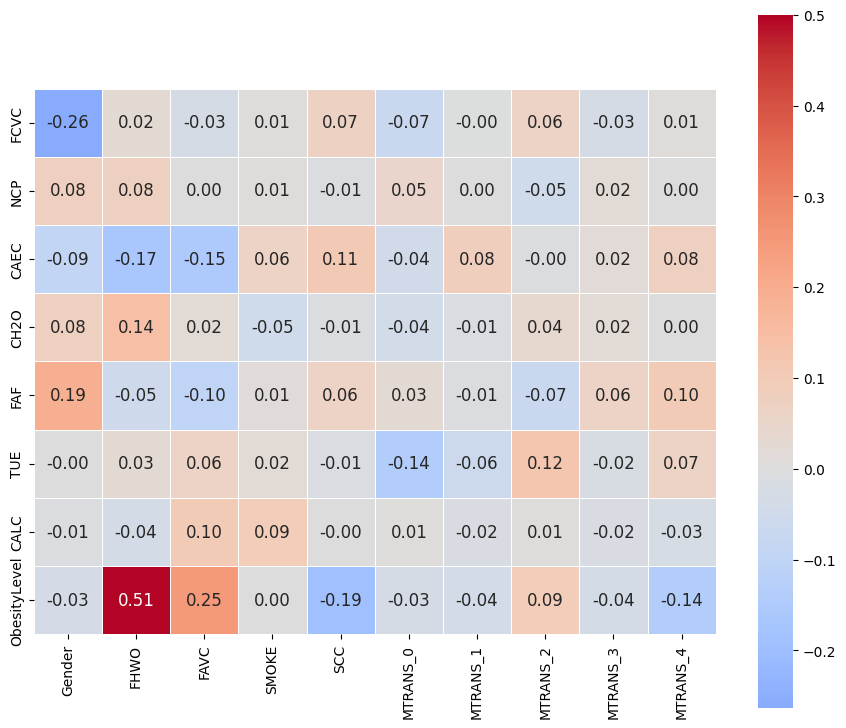

In [28]:
ordinal_nominal_correlation_matrix = pd.DataFrame(index=ordinal_features, columns=nominal_features, dtype=float)

for col_ord in ordinal_features:
    for col_nom in nominal_features:
        r, p_value = pointbiserialr(dataset[col_nom], dataset[col_ord])
        ordinal_nominal_correlation_matrix.loc[col_ord, col_nom] = r

plot_correlation(ordinal_nominal_correlation_matrix)

* il consumo di verdura durante i pasti (`FCVC`) ha una correlazione negativa molto debole con il genere (`Gender`). 
* la frequenza di svolgimento di attività fisica (`FAF`) ha una correlazione molto debole con il genere (`Gender`).
* il consumo di cibo tra i pasti (`CAEC`) ha una correlazione negativa molto debolo con la presenza di familiari che sono o sono stati sovrappeso (`FHWO`) e con il consumo di cibi ad alto contenuto calorico (`FAVC`).
* i litri di acqua assunti in una giornata (`CH2O`) ha una correlazione molto debole con la presenza di familiari che sono o sono stati sovrappeso (`FHWO`).
* la frequenza di utilizzo di dispositivi elettronici (`TUE`) ha una correlazione negativa molto debole con l'utilizzo dell'automobile come mezzo di trasporto (`MTRANS_0`) e una correlazione molto debole con l'utilizzo della bicicletta (`MTRANS_2`).
* il livello di obesità (`ObesityLevel`) ha una correlazione negativa molto debole con il monitoraggio delle calorie giornaliere (`SCC`), una correlazione debole con il consumo di cibo ad alto contenuto calorico (`FAVC`) e una correlazione moderata con la presenza di familiari che sono o sono stati sovrappeso (`FHWO`).

## Parte 3 - Preparazione dei dati

Si calcola l'indice di massa corporea (BMI) di ogni soggetto con la seguente formula
\begin{equation}
BMI = \frac{weight_{kg}}{height_{m}^2}
\end{equation}
e si aggiunge la nuova feature ottenuta al dataset.

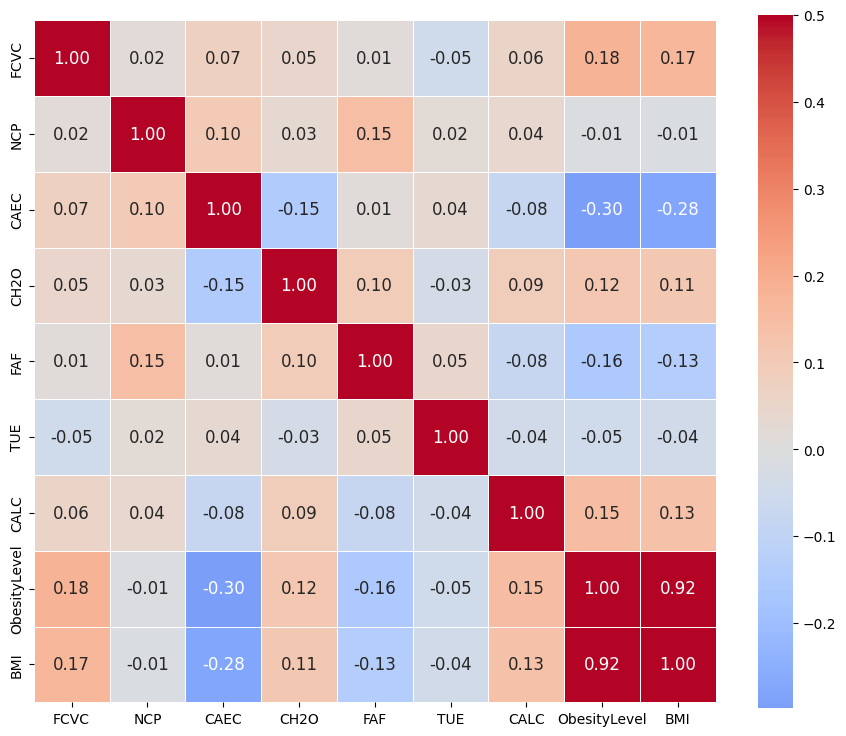

In [29]:
dataset['BMI'] = dataset['Weight'] / (dataset['Height'])**2

ordinal_features = ['FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE', 'CALC', 'ObesityLevel', 'BMI']

ordinal_correlation_matrix = dataset[ordinal_features].corr(method='kendall')
plot_correlation(ordinal_correlation_matrix)

Si osserva la correlazione molto forte della nuova feature (`BMI`) con la variabile target (`ObesityLevel`). Si suppone quindi che sia rilevante per la modellazione; in seguito verrà ne verrà valutato l'impatto effettivo. 

Si procede con l'isolamento della variabile target (`ObesityLevel`) e la suddivisione del dataset in training set e validation set.

In [30]:
from sklearn.model_selection import train_test_split

X = dataset.drop('ObesityLevel', axis=1)
y = dataset['ObesityLevel']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=43, stratify=y.values)

X_no_BMI = dataset.drop(['ObesityLevel', 'BMI'] , axis=1)
y_no_BMI = dataset['ObesityLevel']
X_train_no_BMI, X_val_no_BMI, y_train_no_BMI, y_val_no_BMI = train_test_split(X_no_BMI, y_no_BMI, test_size=0.3, random_state=43, stratify=y.values)


Di seguito viene allenato un modello lineare per verificare l'effettivo impatto dell'aggiunta della feature BMI.<br>
Si valuta inoltre l'utilità di eseguire one-hot encoding sulle feature nominali del dataset.

In [34]:
from sklearn.linear_model import Perceptron
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

ordinal_features = ['FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE', 'CALC', 'BMI']
nominal_features = ["Gender", "FHWO", "FAVC", "SMOKE", "SCC"]

std_perceptron = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", ..., continuous_features),
        ("nominal", ..., nominal_features),
        ("ordinal", ..., ordinal_features),
    ])),
    ('perceptron', OneVsRestClassifier(Perceptron(n_jobs=-1, early_stopping=True, n_iter_no_change=5)))
])

parameters = {
    'preproc__numeric': ['passthrough', StandardScaler()],
    'preproc__nominal': ['passthrough', OneHotEncoder()],
    'preproc__ordinal': ['passthrough', StandardScaler()],
    'perceptron__estimator__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'perceptron__estimator__alpha': [0.0001, 0.001, 0.01, 1],
    'perceptron__estimator__tol': [1e-9, 1e-6, 1e-3, 1, 1e3, 1e6],
}

perceptron_cv = GridSearchCV(std_perceptron, parameters, cv=5, n_jobs=-1, scoring='f1_micro', error_score="raise")
perceptron_cv.fit(X_train, y_train)
print('GridSearch on Perceptron finish')

predictions = perceptron_cv.predict(X_val)

accuracy = accuracy_score(y_val, predictions)
print(f"Accuracy: {accuracy}")
print('Best parameters:', perceptron_cv.best_params_)
print('Best score: {:.4f}%'.format(round(perceptron_cv.best_score_ * 100, 4)))

ValueError: A given column is not a column of the dataframe

In [ ]:
print('Accuracy on train {:.2f}%'.format(perceptron_cv.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(perceptron_cv.score(X_val, y_val)*100))

In [ ]:
ordinal_features = ['FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE', 'CALC']

std_perceptron = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", ..., continuous_features),
        ("nominal", ..., nominal_features),
        ("ordinal", ..., ordinal_features),
    ])),
    ('perceptron', OneVsRestClassifier(Perceptron(n_jobs=-1, early_stopping=True, n_iter_no_change=5)))
])

parameters = {
    'preproc__numeric': ['passthrough', StandardScaler()],
    'preproc__nominal': ['passthrough', OneHotEncoder()],
    'preproc__ordinal': ['passthrough', StandardScaler()],
    'perceptron__estimator__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'perceptron__estimator__alpha': [0.0001, 0.001, 0.01, 1],
    'perceptron__estimator__tol': [1e-9, 1e-6, 1e-3, 1, 1e3, 1e6],
}

perceptron_cv_no_BMI = GridSearchCV(std_perceptron, parameters, cv=5, n_jobs=-1, scoring='f1_micro', error_score="raise")
perceptron_cv_no_BMI.fit(X_train_no_BMI, y_train_no_BMI)
print('GridSearch on Perceptron without BMI finish')

predictions = perceptron_cv_no_BMI.predict(X_val_no_BMI)

accuracy = accuracy_score(y_val_no_BMI, predictions)
print(f"Accuracy: {accuracy}")
print('Best parameters:', perceptron_cv_no_BMI.best_params_)
print('Best score: {:.4f}%'.format(round(perceptron_cv_no_BMI.best_score_ * 100, 4)))

In [ ]:
print('Accuracy on train {:.2f}%'.format(perceptron_cv_no_BMI.score(X_train_no_BMI, y_train_no_BMI)*100))
print('Accuracy on val {:.2f}%'.format(perceptron_cv_no_BMI.score(X_val_no_BMI, y_val_no_BMI)*100))

Alla luce dei risultati delle grid search si conclude che la presenza della feature BMI comporta un leggero aumento dell'accuratezza. L'applicazione del one-hot encoding alle variabili nominali, seppur binarie, viene in entrambi i casi indicata come la scelta migliore.

Si procede di seguito con l'applicazione della codifica sul dataset.

In [36]:
nominal_features = ["Gender_0","Gender_1", "FHWO_False", "FHWO_True", "FAVC_False", "FAVC_True", "SMOKE_False", "SMOKE_True", "SCC_False", "SCC_True", 'MTRANS_0', 'MTRANS_1', 'MTRANS_2', 'MTRANS_3', 'MTRANS_4']
ordinal_features = ['FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE', 'CALC', 'BMI']

dataset = pd.get_dummies(dataset, columns=["Gender", "FHWO", "FAVC", "SMOKE", "SCC"])

X = dataset.drop('ObesityLevel', axis=1)
y = dataset['ObesityLevel']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=43, stratify=y.values)

KeyError: "None of [Index(['Gender', 'FHWO', 'FAVC', 'SMOKE', 'SCC'], dtype='object')] are in the [columns]"

## Parte 4 - Modellazione

In [40]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [41]:
from statsmodels.stats.proportion import proportion_confint

def confidence_interval(instance, acc, confidence):    
    return proportion_confint(instance * acc, instance, 1-confidence/100, method='wilson')

### Perceptron

In [77]:
std_perceptron = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), continuous_features),
        ("nominal", "passthrough", nominal_features),
        ("ordinal", StandardScaler(), ordinal_features)
    ])),
    ('perceptron', OneVsRestClassifier(Perceptron(n_jobs=-1, early_stopping=True, n_iter_no_change=5)))
])

parameters = {
    'perceptron__estimator__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'perceptron__estimator__alpha': [0.0001, 0.001, 0.01, 1],
    'perceptron__estimator__tol': [1e-9, 1e-6, 1e-3, 1, 1e3, 1e6],
}

perceptron_cv = GridSearchCV(std_perceptron, parameters, cv=5, n_jobs=-1, scoring='f1_micro', error_score="raise")
perceptron_cv.fit(X_train, y_train)
print('GridSearch on Perceptron finished')

predictions = perceptron_cv.predict(X_val)

accuracy = accuracy_score(y_val, predictions)
print(f"Accuracy: {accuracy}")
print('Best parameters:', perceptron_cv.best_params_)
print('Best score: {:.4f}%'.format(round(perceptron_cv.best_score_ * 100, 4)))

GridSearch on Perceptron finished
Accuracy: 0.6357827476038339
Best parameters: {'perceptron__estimator__alpha': 0.0001, 'perceptron__estimator__penalty': 'elasticnet', 'perceptron__estimator__tol': 1}
Best score: 64.4521%


In [78]:
print('Accuracy on train {:.2f}%'.format(perceptron_cv.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(perceptron_cv.score(X_val, y_val)*100))

Accuracy on train 63.29%
Accuracy on val 63.58%


In [79]:
confidence = 95
lower, upper = confidence_interval(len(X_val), perceptron_cv.score(X_val, y_val), confidence)

print('Interval with confidence {}%: \nPmin = {:.4f}%\nPmax = {:.4f}%'.format(confidence, lower*100, upper*100))

Interval with confidence 95%: 
Pmin = 59.7365%
Pmax = 67.2545%


In [83]:
len(weights_per_class)

7

<Axes: ylabel='Feature'>

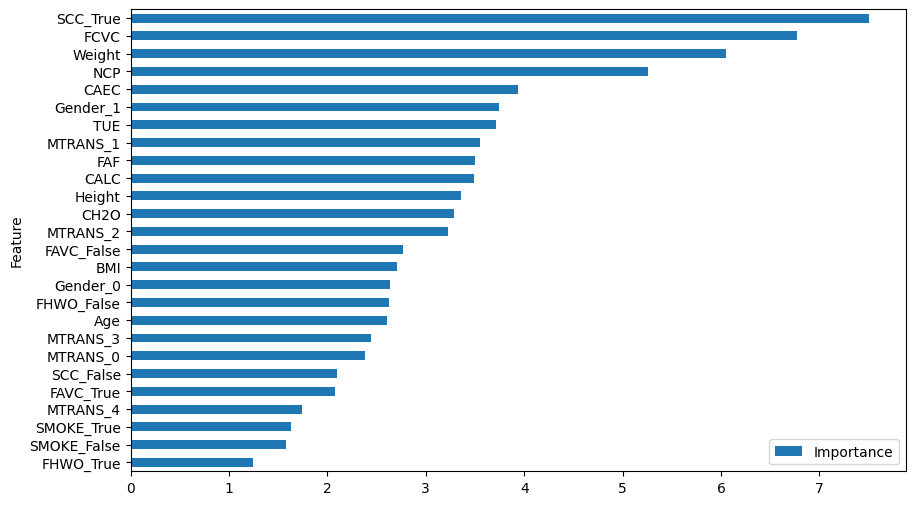

In [80]:
classifiers = perceptron_cv.best_estimator_.named_steps['perceptron'].estimators_
weights_per_class = [classifier.coef_ for classifier in classifiers]
avg_importance = np.mean(np.abs(weights_per_class), axis=0)[0]
feature_importance = pd.DataFrame({'Feature': X_val.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

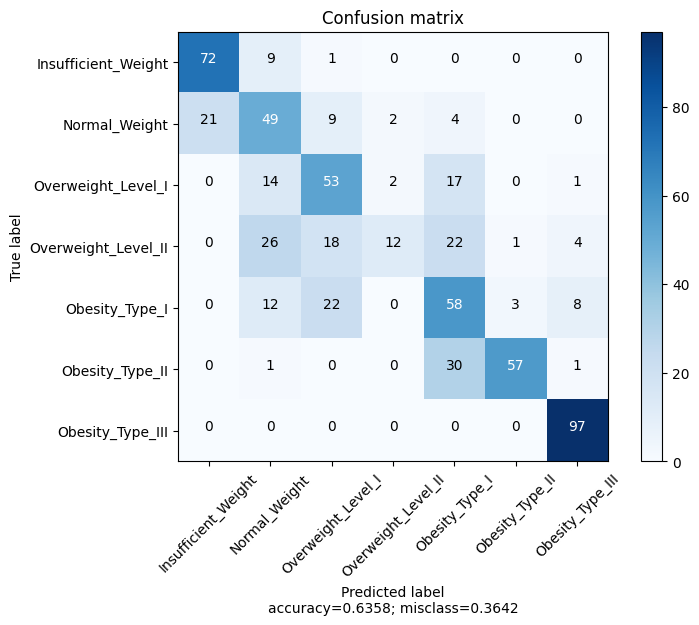

In [122]:
from sklearn.metrics import confusion_matrix

y_pred = perceptron_cv.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

plot_confusion_matrix(cm, target_names=['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'], normalize=False)

In [121]:
from sklearn.metrics import classification_report

pred = perceptron_cv.predict(X_val)
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82        82
           1       0.44      0.58      0.50        85
           2       0.51      0.61      0.56        87
           3       0.75      0.14      0.24        83
           4       0.44      0.56      0.50       103
           5       0.93      0.64      0.76        89
           6       0.87      1.00      0.93        97

    accuracy                           0.64       626
   macro avg       0.68      0.63      0.62       626
weighted avg       0.67      0.64      0.62       626



In [120]:
from sklearn.metrics import mean_squared_error

perceptron_mse = mean_squared_error(y_val, perceptron_cv.predict(X_val))
print('MSE: {}'.format(perceptron_mse))

MSE: 1.036741214057508


### SVM

In [93]:
from sklearn.svm import SVC

svm_pipeline = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), continuous_features),
        ("nominal", "passthrough", nominal_features),
        ("ordinal", StandardScaler(), ordinal_features)
    ])),
    ('svm', SVC(decision_function_shape='ovr'))
])

parameters = {
    'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__degree': [2, 3, 4],
    'svm__gamma': ['scale', 'auto'],
}

svm_cv = GridSearchCV(svm_pipeline, parameters, cv=5, n_jobs=-1, scoring='f1_micro', error_score='raise')
svm_cv.fit(X_train, y_train)
print('GridSearch on SVM finished')

predictions = svm_cv.predict(X_val)

accuracy = accuracy_score(y_val, predictions)
print(f"Accuracy: {accuracy}")
print('Best parameters:', svm_cv.best_params_)
print('Best score: {:.4f}%'.format(round(svm_cv.best_score_ * 100, 4)))

GridSearch on SVM finished
Accuracy: 0.9616613418530351
Best parameters: {'svm__C': 10, 'svm__degree': 2, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best score: 96.5068%


In [94]:
print('Accuracy on train {:.2f}%'.format(svm_cv.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(svm_cv.score(X_val, y_val)*100))

Accuracy on train 98.63%
Accuracy on val 96.17%


In [95]:
confidence = 95
lower, upper = confidence_interval(len(X_val), svm_cv.score(X_val, y_val), confidence)

print('Interval with confidence {}%: \nPmin = {:.4f}%\nPmax = {:.4f}%'.format(confidence, lower*100, upper*100))

Interval with confidence 95%: 
Pmin = 94.3588%
Pmax = 97.4103%


<Axes: ylabel='Feature'>

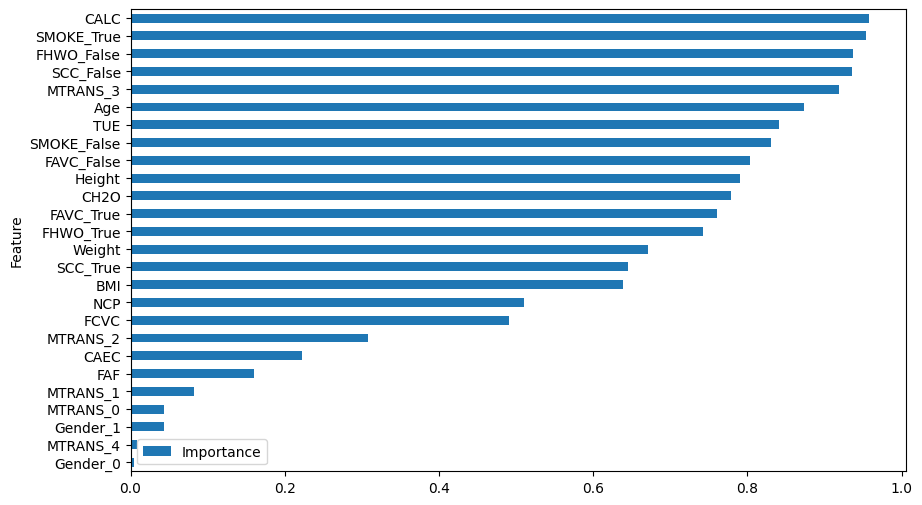

In [97]:
classifiers = svm_cv.best_estimator_.named_steps['svm'].support_vectors_
weights_per_class = [classifier for classifier in classifiers]
avg_importance = np.mean(np.abs(weights_per_class), axis=0)
feature_importance = pd.DataFrame({'Feature': X_val.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

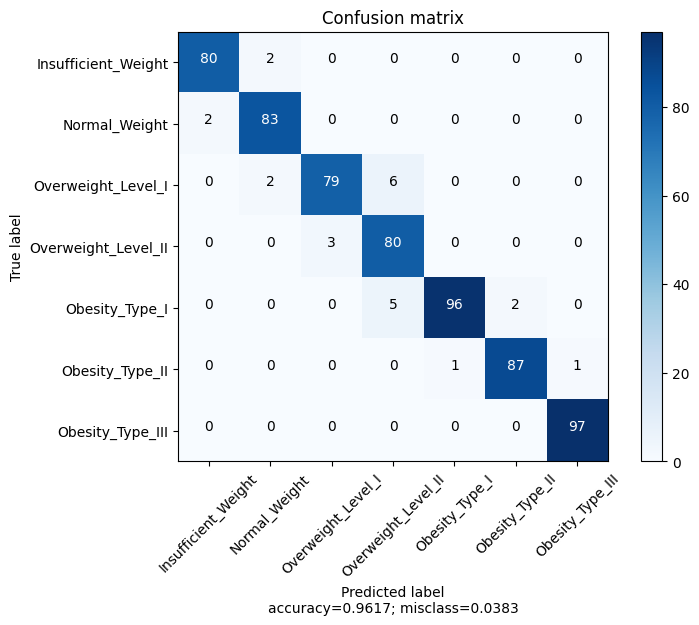

In [98]:
y_pred = svm_cv.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

plot_confusion_matrix(cm, target_names=['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'], normalize=False)

In [99]:
pred = svm_cv.predict(X_val)
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        82
           1       0.95      0.98      0.97        85
           2       0.96      0.91      0.93        87
           3       0.88      0.96      0.92        83
           4       0.99      0.93      0.96       103
           5       0.98      0.98      0.98        89
           6       0.99      1.00      0.99        97

    accuracy                           0.96       626
   macro avg       0.96      0.96      0.96       626
weighted avg       0.96      0.96      0.96       626



In [100]:
svm_mse = mean_squared_error(y_val, svm_cv.predict(X_val))
print('MSE: {}'.format(svm_mse))

MSE: 0.038338658146964855


### Polynomial Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

poly_log_reg_pipeline = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), continuous_features),
        ("nominal", "passthrough", nominal_features),
        ("ordinal", StandardScaler(), ordinal_features)
    ])),
    ("poly",   PolynomialFeatures(degree=2, include_bias=False)),
    ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10000))
])

parameters = [
    {
        'log_reg__penalty': ['l1', 'l2'],
        'log_reg__C': [0.1, 1, 10],
    },
    {
        'log_reg__penalty': ['elasticnet'],
        'log_reg__C': [1],
        "log_reg__l1_ratio": [0.5]
    }
]

poly_log_reg_cv = GridSearchCV(poly_log_reg_pipeline, parameters, cv=5, n_jobs=-1, scoring='f1_micro', error_score='raise')
poly_log_reg_cv.fit(X_train, y_train)
print('GridSearch on Polynomial Logistic Regression finished')

predictions = poly_log_reg_cv.predict(X_val)

accuracy = accuracy_score(y_val, predictions)
print(f"Accuracy: {accuracy}")
print('Best parameters:', poly_log_reg_cv.best_params_)
print('Best score: {:.4f}%'.format(round(poly_log_reg_cv.best_score_ * 100, 4)))

GridSearch on Polynomial Logistic Regression finished
Accuracy: 0.9568690095846646
Best parameters: {'log_reg__C': 1, 'log_reg__penalty': 'l1'}
Best score: 94.5890%


In [38]:
print('Accuracy on train {:.2f}%'.format(poly_log_reg_cv.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(poly_log_reg_cv.score(X_val, y_val)*100))

Accuracy on train 99.86%
Accuracy on val 95.69%


In [45]:
confidence = 95
lower, upper = confidence_interval(len(X_val), poly_log_reg_cv.score(X_val, y_val), confidence)

print('Interval with confidence {}%: \nPmin = {:.4f}%\nPmax = {:.4f}%'.format(confidence, lower*100, upper*100))

Interval with confidence 95%: 
Pmin = 93.7974%
Pmax = 97.0191%


<Axes: ylabel='Feature'>

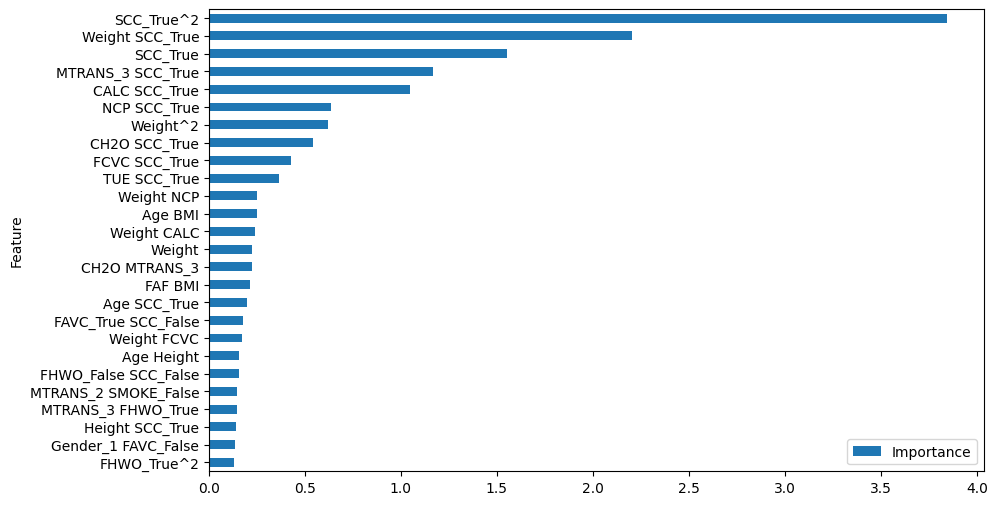

In [149]:
classifiers = poly_log_reg_cv.best_estimator_.named_steps['log_reg'].coef_
weights_per_class = [classifier for classifier in classifiers]
avg_importance = np.mean(np.abs(weights_per_class), axis=0)
feature_importance = pd.DataFrame({'Feature': poly_log_reg_cv.best_estimator_.named_steps['poly'].get_feature_names_out(X_val.columns), 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

feature_importance.tail(26).plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

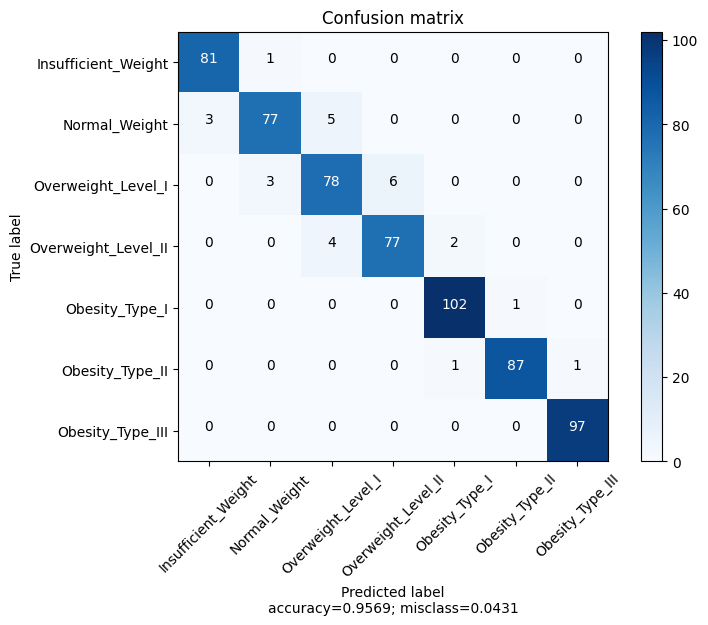

In [48]:
y_pred = poly_log_reg_cv.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

plot_confusion_matrix(cm, target_names=['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'], normalize=False)

In [49]:
pred = poly_log_reg_cv.predict(X_val)
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98        82
           1       0.95      0.91      0.93        85
           2       0.90      0.90      0.90        87
           3       0.93      0.93      0.93        83
           4       0.97      0.99      0.98       103
           5       0.99      0.98      0.98        89
           6       0.99      1.00      0.99        97

    accuracy                           0.96       626
   macro avg       0.96      0.96      0.96       626
weighted avg       0.96      0.96      0.96       626



In [50]:
poly_log_reg_mse = mean_squared_error(y_val, poly_log_reg_cv.predict(X_val))
print('MSE: {}'.format(poly_log_reg_mse))

MSE: 0.04313099041533546


### Random forest

In [96]:
from sklearn.ensemble import RandomForestClassifier

rfc_pipeline = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), continuous_features),
        ("nominal", "passthrough", nominal_features),
        ("ordinal", StandardScaler(), ordinal_features)
    ])),
    ('rfc', RandomForestClassifier(n_jobs=-1, random_state=3))
])

parameters = {
    'rfc__n_estimators': [100, 200, 300],
    'rfc__max_depth': [2, 4, 6, 8, 10],
    'rfc__min_samples_leaf': [1, 2, 4],
    'rfc__min_samples_split': [2, 5, 10],
}

rfc_cv = GridSearchCV(rfc_pipeline, parameters, cv=5, n_jobs=-1, scoring='f1_micro', error_score='raise')
rfc_cv.fit(X_train, y_train)
print('GridSearch on Random Forest finished')

predictions = rfc_cv.predict(X_val)

accuracy = accuracy_score(y_val, predictions)
print(f"Accuracy: {accuracy}")
print('Best parameters:', rfc_cv.best_params_)
print('Best score: {:.4f}%'.format(round(rfc_cv.best_score_ * 100, 4)))

GridSearch on Polynomial Logistic Regression finished
Accuracy: 0.987220447284345
Best parameters: {'rfc__max_depth': 10, 'rfc__min_samples_leaf': 2, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 200}
Best score: 98.7671%


In [104]:
print('Accuracy on train {:.2f}%'.format(rfc_cv.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(rfc_cv.score(X_val, y_val)*100))

Accuracy on train 100.00%
Accuracy on val 98.72%


In [105]:
confidence = 95
lower, upper = confidence_interval(len(X_val), rfc_cv.score(X_val, y_val), confidence)

print('Interval with confidence {}%: \nPmin = {:.4f}%\nPmax = {:.4f}%'.format(confidence, lower*100, upper*100))

Interval with confidence 95%: 
Pmin = 97.4987%
Pmax = 99.3510%


<Axes: ylabel='Feature'>

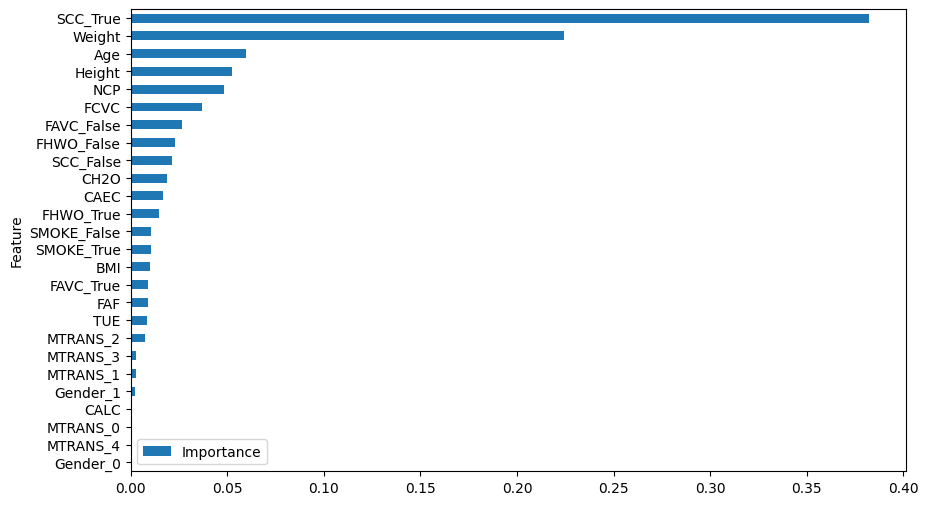

In [116]:
feature_importance = pd.DataFrame({'Feature': X_val.columns, 'Importance': rfc_cv.best_estimator_.named_steps['rfc'].feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

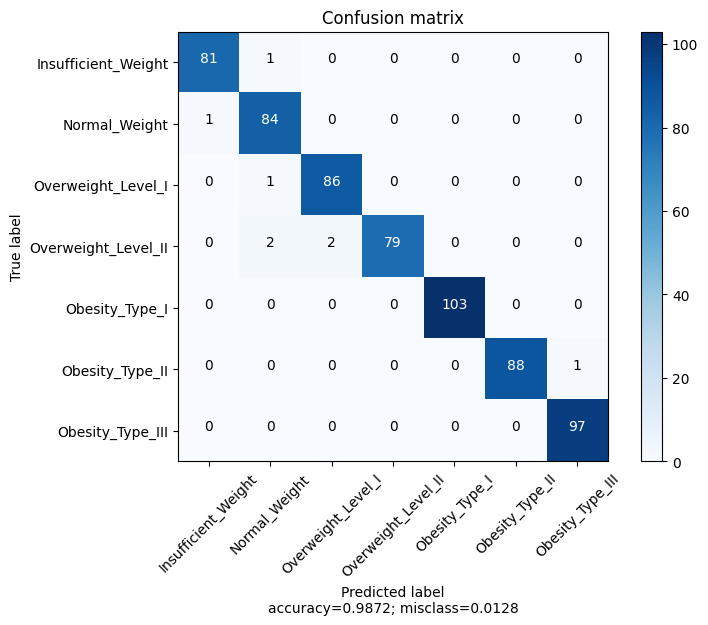

In [117]:
y_pred = rfc_cv.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

plot_confusion_matrix(cm, target_names=['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'], normalize=False)

In [118]:
pred = rfc_cv.predict(X_val)
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        82
           1       0.95      0.99      0.97        85
           2       0.98      0.99      0.98        87
           3       1.00      0.95      0.98        83
           4       1.00      1.00      1.00       103
           5       1.00      0.99      0.99        89
           6       0.99      1.00      0.99        97

    accuracy                           0.99       626
   macro avg       0.99      0.99      0.99       626
weighted avg       0.99      0.99      0.99       626



In [139]:
rfc_mse = mean_squared_error(y_val, rfc_cv.predict(X_val))
print('MSE: {}'.format(rfc_mse))

MSE: 0.01437699680511182


### XGBoost

In [130]:
from xgboost import XGBClassifier

rfc_pipeline = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), continuous_features),
        ("nominal", "passthrough", nominal_features),
        ("ordinal", StandardScaler(), ordinal_features)
    ])),
    ('xgb', XGBClassifier(nthread=8, objective='multi:softprob'))
])

parameters = {
    'xgb__eta': [0.001, 0.1, 0.5],
    'xgb__max_depth': [3, 5, 7],
    'xgb__n_estimators': [150, 300],
    'xgb__alpha': [0.0001, 0.001],
}

rfc_cv = GridSearchCV(rfc_pipeline, parameters, cv=5, n_jobs=-1, scoring='f1_micro', error_score='raise')
rfc_cv.fit(X_train, y_train)
print('GridSearch on Random Forest finished')

predictions = rfc_cv.predict(X_val)

accuracy = accuracy_score(y_val, predictions)
print(f"Accuracy: {accuracy}")
print('Best parameters:', rfc_cv.best_params_)
print('Best score: {:.4f}%'.format(round(rfc_cv.best_score_ * 100, 4)))

GridSearch on Random Forest finished
Accuracy: 0.9856230031948882
Best parameters: {'xgb__alpha': 0.0001, 'xgb__eta': 0.5, 'xgb__max_depth': 3, 'xgb__n_estimators': 300}
Best score: 98.1507%


In [131]:
print('Accuracy on train {:.2f}%'.format(xgb_cv.score(X_train, y_train)*100))
print('Accuracy on val {:.2f}%'.format(xgb_cv.score(X_val, y_val)*100))

Accuracy on train 100.00%
Accuracy on val 98.56%


In [132]:
confidence = 95
lower, upper = confidence_interval(len(X_val), xgb_cv.score(X_val, y_val), confidence)

print('Interval with confidence {}%: \nPmin = {:.4f}%\nPmax = {:.4f}%'.format(confidence, lower*100, upper*100))

Interval with confidence 95%: 
Pmin = 97.2904%
Pmax = 99.2418%


<Axes: ylabel='Feature'>

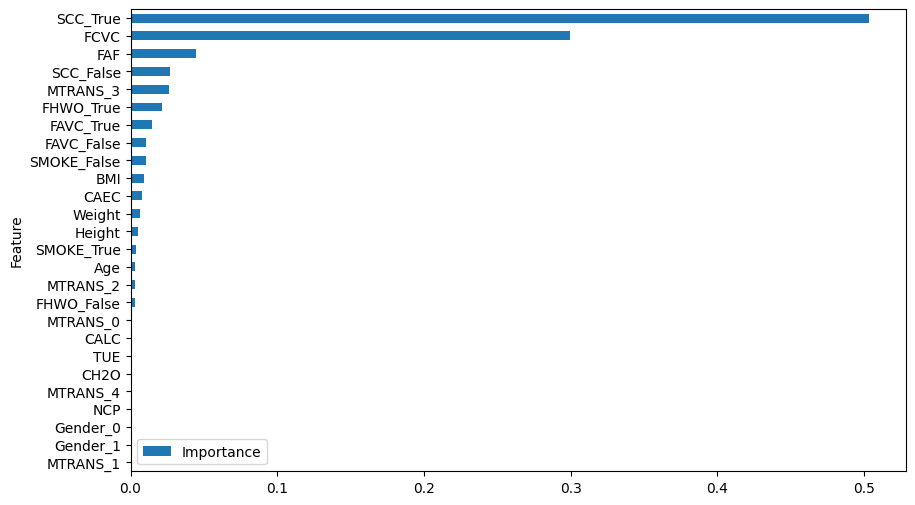

In [134]:
feature_importance = pd.DataFrame({'Feature': X_val.columns, 'Importance': xgb_cv.best_estimator_.named_steps['xgb'].feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

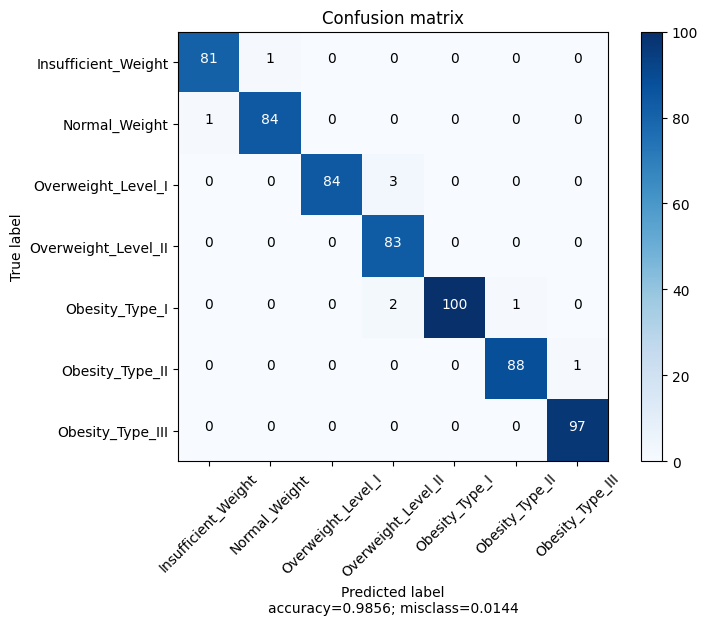

In [135]:
y_pred = xgb_cv.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

plot_confusion_matrix(cm, target_names=['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'], normalize=False)

In [136]:
pred = xgb_cv.predict(X_val)
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        82
           1       0.99      0.99      0.99        85
           2       1.00      0.97      0.98        87
           3       0.94      1.00      0.97        83
           4       1.00      0.97      0.99       103
           5       0.99      0.99      0.99        89
           6       0.99      1.00      0.99        97

    accuracy                           0.99       626
   macro avg       0.99      0.99      0.99       626
weighted avg       0.99      0.99      0.99       626



In [138]:
xgb_mse = mean_squared_error(y_val, xgb_cv.predict(X_val))
print('MSE: {}'.format(xgb_mse))

MSE: 0.01437699680511182
